In \[ \]:

    # GETTING THE IDS FROM IMDB:
    from bs4 import BeautifulSoup
    import pandas as pd
    import requests
    import time
    import re

    def get_movie_url(year):
        url = ('https://www.imdb.com/search/title/?title_type=feature&boxoffice_gross_us=1,&release_date='+str(year)+'-01-01,'+str(year)+'-12-31&countries=us&view=simple&count=250')
        url2 = ('https://www.imdb.com/search/title/?title_type=feature&boxoffice_gross_us=1,&&release_date='+str(year)+'-01-01,'+str(year)+'-12-31&countries=us&view=simple&count=250&start=251')
        headers = {'Accept-Language': 'en-US'}
        movies_html = requests.get(url.format(), headers=headers).content
        movies2_html = requests.get(url2.format(), headers=headers).content
        soup = BeautifulSoup(movies_html, 'html.parser')
        soup2 = BeautifulSoup(movies2_html, 'html.parser')
        soup_main = soup.find("div", {"id": "main"})
        soup_main2 = soup2.find("div", {"id": "main"})
        movies = soup_main.findAll('a', {'href': re.compile('/title/tt')})
        movies2 = soup_main2.findAll('a', {'href': re.compile('/title/tt')})
        # create an array to house all **UNIQUE** ids for each movie
        ids_for_movies_in_year = []
        for movie in movies:
            # Getting the movie attributes, splitting them on '/'
            title_id = movie.attrs['href'].split('/')[2]
            # Here is where we are saying "does this ID already exist in our array? No? OK add it!"
            if title_id not in ids_for_movies_in_year: 
                ids_for_movies_in_year.append(title_id)
                # Testing
                # print(movie.attrs['href'].split('/')[2])
        for movie in movies2:
            # Getting the movie attributes, splitting them on '/'
            title_id = movie.attrs['href'].split('/')[2]
            # Here is where we are saying "does this ID already exist in our array? No? OK add it!"
            if title_id not in ids_for_movies_in_year: 
                ids_for_movies_in_year.append(title_id)
                # Testing
                # print(movie.attrs['href'].split('/')[2])
        return(ids_for_movies_in_year)

    all_the_ids = []
    for year in range(1970, 2020):
        all_the_ids.append((get_movie_url(year)))

    all_the_ids_df = pd.DataFrame(all_the_ids)
    all_the_ids_df.to_csv(r'imdb_ids.csv')

    all_the_2018_ids_df = pd.DataFrame(all_the_ids[48])
    all_the_2018_ids_df.to_csv(r'imdb_ids_2018.csv')

In \[ \]:

    # GETTING THE DATA FROM THE TMDB API (THE JSON!):
    # import requests
    import json
    import csv
    from urllib.parse import quote

    def write_csv(data):
        df = pd.DataFrame(data)
        df.to_csv('2018_movies.csv', index=False)

    headers = {'Accept-Language': 'en-US'}
    payload = "{}"

    api_key = open("tmdb_api_key.txt")
    api_key = api_key.read()

    all_movie_data = []
    with open('imdb_ids_2018.csv', encoding='utf-8') as csvfile:
        movies = csv.reader(csvfile)
        for movie in movies:
            try:
                url = "https://api.themoviedb.org/3/movie/"
                thing_looking_for = movie[1]
                my_api_key = "?api_key=" + api_key
                full_url = url + thing_looking_for + my_api_key
                res = requests.get(full_url, payload, headers=headers)
                data = res.content.decode('UTF-8')
                jdata = json.loads(data)
                try:
                    title = jdata['title']
                    budget = jdata['budget']
                    genres = jdata['genres']
                    production_companies = jdata['production_companies']
                    release_date = jdata['release_date']
                    revenue = jdata['revenue']
                    profit = revenue - budget
                    popularity = jdata['popularity']
                    vote_average = jdata['vote_average']
                    vote_count = jdata['vote_count']
                except KeyError:
                    title = 'NA'
                    budget = 'NA'
                    genres = 'NA'
                    production_companies = 'NA'
                    release_date = 'NA'
                    revenue = 'NA'
                    profit = 'NA'
                    popularity = 'NA'
                    vote_average = 'NA'
                    vote_count = 'NA'

                movie_data = {
                    'release_date': release_date,
                    'title': title,
                    'budget': budget,
                    'genres': genres,
                    'production_companies': production_companies,
                    'revenue': revenue,
                    'profit': profit,
                    'popularity': popularity,
                    'vote_average': vote_average,
                    'vote_count': vote_count
                }
                all_movie_data.append(movie_data)
            except UnicodeDecodeError:
                director_data = {}
    all_movie_data_df = pd.DataFrame(all_movie_data)
    print(all_movie_data_df)
    write_csv(all_movie_data)

In \[40\]:

    # ANALYZING THE JSON DATA

    #Packages that will be used in this notebook
    # import pandas as pd 
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    #For this assignment, we are using the movies data set that we got from tmdb using their JSON api. 


    #Reading in the csv file using pandas' read.csv function 
    movies = pd.read_csv('2018_movies.csv')
    #Pandas was able to recognize that the first row of data was the column names, this was helpful because when we downloaded 
    #the csv after getting the information, our csv did not include proper column names, instead the column names were in 
    #the first row of our data. pd.read_csv correctly noticed that the first row of our file contained the column names. 

In \[41\]:

    #Looking at the movies df...
    movies
    # Pandas recognized that the first row was the column names and moved the first row to column names,
    #however it left the first row blank... We need to remove that row

Out\[41\]:

|     | release\_date | title                                       | budget       | genres                                             | production\_companies                               | revenue      | profit        | popularity | vote\_average | vote\_count |
|-----|---------------|---------------------------------------------|--------------|----------------------------------------------------|-----------------------------------------------------|--------------|---------------|------------|---------------|-------------|
| 0   | NaN           | NaN                                         | NaN          | NaN                                                | NaN                                                 | NaN          | NaN           | NaN        | NaN           | NaN         |
| 1   | 2018-12-07    | Aquaman                                     | 160000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | 1.143689e+09 | 9.836892e+08  | 28.789     | 6.8           | 6781.0      |
| 2   | 2019-08-29    | Night Hunter                                | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 109529, 'logo\_path': None, 'name': 'Ar... | 0.000000e+00 | 0.000000e+00  | 48.191     | 0.0           | 13.0        |
| 3   | 2018-12-06    | Spider-Man: Into the Spider-Verse           | 90000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | 3.754504e+08 | 2.854504e+08  | 39.780     | 8.4           | 4808.0      |
| 4   | 2018-10-24    | Bohemian Rhapsody                           | 52000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | 8.940275e+08 | 8.420275e+08  | 35.534     | 8.1           | 8357.0      |
| 5   | 1985-07-13    | Live Aid                                    | 0.0          | \[{'id': 10402, 'name': 'Music'}, {'id': 99, 'n... | \[{'id': 3065, 'logo\_path': '/sJ919bmS8B53hujwb... | 0.000000e+00 | 0.000000e+00  | 2.065      | 7.8           | 23.0        |
| 6   | 2018-04-25    | Avengers: Infinity War                      | 300000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 2.046240e+09 | 1.746240e+09  | 71.537     | 8.3           | 14913.0     |
| 7   | 2019-08-15    | Driven                                      | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n... | \[{'id': 60622, 'logo\_path': None, 'name': 'Tem... | 0.000000e+00 | 0.000000e+00  | 39.114     | 5.7           | 9.0         |
| 8   | 2018-06-07    | Hereditary                                  | 10000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | 7.933682e+07 | 6.933682e+07  | 29.333     | 7.0           | 2797.0      |
| 9   | 2018-11-14    | Fantastic Beasts: The Crimes of Grindelwald | 200000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 14, '... | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | 6.533559e+08 | 4.533559e+08  | 36.627     | 6.9           | 5320.0      |
| 10  | 2018-11-23    | The Favourite                               | 15000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name... | \[{'id': 22842, 'logo\_path': '/waIZoO3pnB0VVCUV... | 8.212480e+07 | 6.712480e+07  | 23.448     | 7.6           | 2387.0      |
| 11  | 2018-10-03    | A Star Is Born                              | 36000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n... | \[{'id': 3528, 'logo\_path': '/cCzCClIzIh81Fa79h... | 4.338889e+08 | 3.978889e+08  | 26.058     | 7.5           | 6236.0      |
| 12  | 2018-08-29    | A Simple Favor                              | 20000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 61791, 'logo\_path': '/f72ubyCeowgOQO7n... | 5.354242e+07 | 3.354242e+07  | 23.197     | 6.6           | 1961.0      |
| 13  | 2018-08-15    | Crazy Rich Asians                           | 30000000.0   | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 5420, 'logo\_path': '/dlW4Kh5dNieKNURny... | 2.379946e+08 | 2.079946e+08  | 15.469     | 7.1           | 1643.0      |
| 14  | 2018-07-13    | Mission: Impossible - Fallout               | 178000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 4, 'logo\_path': '/fycMZt242LVjagMByZOL... | 7.910175e+08 | 6.130175e+08  | 27.676     | 7.3           | 4063.0      |
| 15  | 2018-11-06    | Widows                                      | 42000000.0   | \[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name... | \[{'id': 10104, 'logo\_path': '/hNuGhsKVlmhnwSRc... | 7.386609e+07 | 3.186609e+07  | 18.947     | 6.5           | 1032.0      |
| 16  | 2018-10-04    | Bad Times at the El Royale                  | 32000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 25, 'logo\_path': '/qZCc1lty5FzX30aOCVR... | 3.188272e+07 | -1.172760e+05 | 15.930     | 6.8           | 1606.0      |
| 17  | 2018-12-13    | Mary Poppins Returns                        | 130000000\.0 | \[{'id': 14, 'name': 'Fantasy'}, {'id': 10751, ... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 3.488071e+08 | 2.188071e+08  | 25.464     | 6.6           | 1655.0      |
| 18  | 2018-11-16    | Green Book                                  | 23000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 6735, 'logo\_path': '/6yyByQrmTAgJv0QzZ... | 3.197000e+08 | 2.967000e+08  | 34.561     | 8.3           | 4029.0      |
| 19  | 2018-05-10    | Deadpool 2                                  | 110000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam... | \[{'id': 7505, 'logo\_path': '/837VMM4wOkODc1idN... | 7.415474e+08 | 6.315474e+08  | 35.220     | 7.5           | 9295.0      |
| 20  | 2018-10-11    | First Man                                   | 70000000.0   | \[{'id': 36, 'name': 'History'}, {'id': 18, 'na... | \[{'id': 7, 'logo\_path': '/vru2SssLX3FPhnKZGtYw... | 1.005462e+08 | 3.054615e+07  | 23.927     | 7.1           | 2593.0      |
| 21  | 2019-08-09    | Brian Banks                                 | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 14.553     | 6.0           | 1.0         |
| 22  | 2018-02-13    | Black Panther                               | 200000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 1.346739e+09 | 1.146739e+09  | 43.354     | 7.4           | 13019.0     |
| 23  | 2018-09-28    | Venom                                       | 116000000\.0 | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 31828, 'logo\_path': None, 'name': 'Avi... | 8.550140e+08 | 7.390140e+08  | 34.764     | 6.6           | 6851.0      |
| 24  | 2018-04-03    | A Quiet Place                               | 17000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 18, 'nam... | \[{'id': 29312, 'logo\_path': None, 'name': 'Sun... | 3.406772e+08 | 3.236772e+08  | 20.956     | 7.3           | 6240.0      |
| 25  | 2018-07-30    | BlacKkKlansman                              | 15000000.0   | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 3172, 'logo\_path': '/kDedjRZwO8uyFhuHa... | 4.868660e+07 | 3.368660e+07  | 20.828     | 7.6           | 3484.0      |
| 26  | 2019-07-26    | Skin                                        | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 19640, 'logo\_path': '/p8SE7J23xviBArUL... | 0.000000e+00 | 0.000000e+00  | 16.434     | 7.1           | 32.0        |
| 27  | 2018-02-28    | Red Sparrow                                 | 69000000.0   | \[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '... | \[{'id': 99426, 'logo\_path': None, 'name': 'Sou... | 1.479882e+08 | 7.898819e+07  | 14.308     | 6.5           | 3558.0      |
| 28  | 2018-11-20    | Ralph Breaks the Internet                   | 175000000\.0 | \[{'id': 10751, 'name': 'Family'}, {'id': 16, '... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 5.292212e+08 | 3.542212e+08  | 35.588     | 7.2           | 3066.0      |
| 29  | 2018-10-11    | Suspiria                                    | 20000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam... | \[{'id': 10989, 'logo\_path': None, 'name': 'Mus... | 6.348889e+06 | -1.365111e+07 | 14.431     | 7.0           | 867.0       |
| ... | ...           | ...                                         | ...          | ...                                                | ...                                                 | ...          | ...           | ...        | ...           | ...         |
| 473 | 2018-03-15    | The Matchmaker's Playbook                   | 0.0          | \[{'id': 10749, 'name': 'Romance'}\]               | \[{'id': 92153, 'logo\_path': '/psjvYkjjgAPtS8ut... | 0.000000e+00 | 0.000000e+00  | 3.408      | 6.0           | 11.0        |
| 474 | 2018-08-26    | Marfa Girl 2                                | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 3.725      | 6.0           | 4.0         |
| 475 | 2018-06-20    | The Work Wife                               | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 6679, 'logo\_path': None, 'name': 'MarV... | 0.000000e+00 | 0.000000e+00  | 1.403      | 5.0           | 3.0         |
| 476 | 2018-11-30    | A Christmas Prince: The Royal Wedding       | 0.0          | \[{'id': 10749, 'name': 'Romance'}, {'id': 35, ... | \[{'id': 2090, 'logo\_path': '/jYlUttNqcN5u1pzMQ... | 0.000000e+00 | 0.000000e+00  | 8.822      | 6.4           | 441.0       |
| 477 | 2018-11-13    | Nazi Overlord                               | 0.0          | \[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam... | \[{'id': 1311, 'logo\_path': '/ic2bTizdzRLDVzAvN... | 0.000000e+00 | 0.000000e+00  | 4.910      | 3.6           | 10.0        |
| 478 | 2018-02-23    | Half Magic                                  | 0.0          | \[{'id': 10749, 'name': 'Romance'}, {'id': 35, ... | \[{'id': 56236, 'logo\_path': None, 'name': 'The... | 0.000000e+00 | 0.000000e+00  | 3.622      | 5.5           | 17.0        |
| 479 | 2018-11-08    | Watch If You Dare                           | 0.0          | \[{'id': 27, 'name': 'Horror'}\]                   | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.691      | 2.8           | 4.0         |
| 480 | 2018-03-30    | God's Not Dead: A Light in Darkness         | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 79986, 'logo\_path': None, 'name': 'Pur... | 5.728940e+06 | 5.728940e+06  | 6.814      | 6.9           | 50.0        |
| 481 | 2018-05-11    | The Honor List                              | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 2.948      | 6.6           | 11.0        |
| 482 | 2018-01-07    | Dead Sexy                                   | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 106003, 'logo\_path': None, 'name': 'Ea... | 0.000000e+00 | 0.000000e+00  | 4.464      | 2.0           | 4.0         |
| 483 | 2018-05-18    | Hurricane Bianca: From Russia with Hate     | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 5.169      | 5.5           | 85.0        |
| 484 | 2018-10-06    | We the Animals                              | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 12219, 'logo\_path': '/2ddXaM0AHMpAl3tm... | 0.000000e+00 | 0.000000e+00  | 4.963      | 6.8           | 47.0        |
| 485 | 2018-03-11    | Perfect                                     | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 878, '... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.859      | 3.5           | 2.0         |
| 486 | 2018-06-12    | Alex & Me                                   | 0.0          | \[{'id': 10751, 'name': 'Family'}\]                | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | 0.000000e+00 | 0.000000e+00  | 3.305      | 7.3           | 34.0        |
| 487 | 2018-04-16    | When Jeff Tried to Save The World           | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 96203, 'logo\_path': None, 'name': '71 ... | 0.000000e+00 | 0.000000e+00  | 1.501      | 4.8           | 6.0         |
| 488 | 2019-06-04    | The Odds                                    | 0.0          | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 118114, 'logo\_path': None, 'name': 'Up... | 0.000000e+00 | 0.000000e+00  | 2.427      | 6.8           | 4.0         |
| 489 | 2018-04-13    | Sgt. Stubby: An American Hero               | 25000000.0   | \[{'id': 16, 'name': 'Animation'}, {'id': 12, '... | \[{'id': 112595, 'logo\_path': None, 'name': 'Fu... | 0.000000e+00 | -2.500000e+07 | 5.350      | 6.3           | 14.0        |
| 490 | 2016-09-26    | Unbelievable!!!!!                           | 2500000.0    | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 48137, 'logo\_path': None, 'name': 'Arc... | 0.000000e+00 | -2.500000e+06 | 1.141      | 6.0           | 1.0         |
| 491 | 2018-04-28    | Better Start Running                        | 0.0          | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 4560, 'logo\_path': None, 'name': 'Tunn... | 0.000000e+00 | 0.000000e+00  | 3.945      | 5.6           | 8.0         |
| 492 | 2018-02-13    | For the Love of George                      | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 0.600      | 2.5           | 2.0         |
| 493 | 2017-01-01    | House of Deadly Secrets                     | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 10770,... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 4.048      | 4.4           | 10.0        |
| 494 | 2018-01-21    | Funny Story                                 | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 88931, 'logo\_path': None, 'name': 'Cin... | 0.000000e+00 | 0.000000e+00  | 2.055      | 6.5           | 5.0         |
| 495 | 2018-10-12    | Stella's Last Weekend                       | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 88926, 'logo\_path': '/25xVamxaglo1Aie5... | 0.000000e+00 | 0.000000e+00  | 1.831      | 7.7           | 9.0         |
| 496 | 2019-08-16    | One Last Night                              | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.960      | 0.0           | 1.0         |
| 497 | 2018-10-26    | 1985                                        | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 109509, 'logo\_path': None, 'name': 'Mu... | 0.000000e+00 | 0.000000e+00  | 4.421      | 6.7           | 10.0        |
| 498 | 2018-11-16    | Tinker'                                     | 0.0          | \[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name... | \[{'id': 111954, 'logo\_path': None, 'name': 'Ko... | 0.000000e+00 | 0.000000e+00  | 2.475      | 4.8           | 4.0         |
| 499 | 2018-06-19    | Weight                                      | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 17883, 'logo\_path': None, 'name': 'Dif... | 0.000000e+00 | 0.000000e+00  | 0.600      | 0.0           | 0.0         |
| 500 | 2018-10-26    | Killer Kate!                                | 200000.0     | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 107820, 'logo\_path': '/qJbFNOiKtaK8cVK... | 0.000000e+00 | -2.000000e+05 | 1.904      | 4.1           | 8.0         |
| 501 | 2018-03-09    | Duck Duck Goose                             | 0.0          | \[{'id': 16, 'name': 'Animation'}, {'id': 10751... | \[{'id': 71194, 'logo\_path': None, 'name': 'Ori... | 0.000000e+00 | 0.000000e+00  | 8.271      | 6.3           | 82.0        |
| 502 | 2019-01-04    | State Like Sleep                            | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 19632, 'logo\_path': '/q2kFlMm4C9UTWgSr... | 0.000000e+00 | 0.000000e+00  | 4.428      | 4.8           | 10.0        |

503 rows × 10 columns

In \[42\]:

    #first getting the length of our df 
    movies.shape
    #We have 503 rows and 10 columns 

Out\[42\]:

    (503, 10)

In \[43\]:

    #removing the first row using the drop function. We are specifying that we are 
    #removing row 0 and leaving columns blank to show that we are removing all columns from row 0.
    movies = movies.drop([0,])

In \[44\]:

    #Checking to make sure that this worked... If it did our new row count will be 502. 
    movies.shape
    #It did!

Out\[44\]:

    (502, 10)

In \[45\]:

    #removing rows with missing values to do this we are using the dropna function in pandas and setting inplace = True
    #which means to replace the original movies df with the movies df that has the rows with missing values removed 
    movies.dropna(inplace = True)

In \[46\]:

    movies.shape
    #We can see that 4 rows had missing values and were dropped 

Out\[46\]:

    (498, 10)

In \[47\]:

    movies

Out\[47\]:

|     | release\_date | title                                       | budget       | genres                                             | production\_companies                               | revenue      | profit        | popularity | vote\_average | vote\_count |
|-----|---------------|---------------------------------------------|--------------|----------------------------------------------------|-----------------------------------------------------|--------------|---------------|------------|---------------|-------------|
| 1   | 2018-12-07    | Aquaman                                     | 160000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | 1.143689e+09 | 9.836892e+08  | 28.789     | 6.8           | 6781.0      |
| 2   | 2019-08-29    | Night Hunter                                | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 109529, 'logo\_path': None, 'name': 'Ar... | 0.000000e+00 | 0.000000e+00  | 48.191     | 0.0           | 13.0        |
| 3   | 2018-12-06    | Spider-Man: Into the Spider-Verse           | 90000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | 3.754504e+08 | 2.854504e+08  | 39.780     | 8.4           | 4808.0      |
| 4   | 2018-10-24    | Bohemian Rhapsody                           | 52000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | 8.940275e+08 | 8.420275e+08  | 35.534     | 8.1           | 8357.0      |
| 5   | 1985-07-13    | Live Aid                                    | 0.0          | \[{'id': 10402, 'name': 'Music'}, {'id': 99, 'n... | \[{'id': 3065, 'logo\_path': '/sJ919bmS8B53hujwb... | 0.000000e+00 | 0.000000e+00  | 2.065      | 7.8           | 23.0        |
| 6   | 2018-04-25    | Avengers: Infinity War                      | 300000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 2.046240e+09 | 1.746240e+09  | 71.537     | 8.3           | 14913.0     |
| 7   | 2019-08-15    | Driven                                      | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n... | \[{'id': 60622, 'logo\_path': None, 'name': 'Tem... | 0.000000e+00 | 0.000000e+00  | 39.114     | 5.7           | 9.0         |
| 8   | 2018-06-07    | Hereditary                                  | 10000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | 7.933682e+07 | 6.933682e+07  | 29.333     | 7.0           | 2797.0      |
| 9   | 2018-11-14    | Fantastic Beasts: The Crimes of Grindelwald | 200000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 14, '... | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | 6.533559e+08 | 4.533559e+08  | 36.627     | 6.9           | 5320.0      |
| 10  | 2018-11-23    | The Favourite                               | 15000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name... | \[{'id': 22842, 'logo\_path': '/waIZoO3pnB0VVCUV... | 8.212480e+07 | 6.712480e+07  | 23.448     | 7.6           | 2387.0      |
| 11  | 2018-10-03    | A Star Is Born                              | 36000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n... | \[{'id': 3528, 'logo\_path': '/cCzCClIzIh81Fa79h... | 4.338889e+08 | 3.978889e+08  | 26.058     | 7.5           | 6236.0      |
| 12  | 2018-08-29    | A Simple Favor                              | 20000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 61791, 'logo\_path': '/f72ubyCeowgOQO7n... | 5.354242e+07 | 3.354242e+07  | 23.197     | 6.6           | 1961.0      |
| 13  | 2018-08-15    | Crazy Rich Asians                           | 30000000.0   | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 5420, 'logo\_path': '/dlW4Kh5dNieKNURny... | 2.379946e+08 | 2.079946e+08  | 15.469     | 7.1           | 1643.0      |
| 14  | 2018-07-13    | Mission: Impossible - Fallout               | 178000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 4, 'logo\_path': '/fycMZt242LVjagMByZOL... | 7.910175e+08 | 6.130175e+08  | 27.676     | 7.3           | 4063.0      |
| 15  | 2018-11-06    | Widows                                      | 42000000.0   | \[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name... | \[{'id': 10104, 'logo\_path': '/hNuGhsKVlmhnwSRc... | 7.386609e+07 | 3.186609e+07  | 18.947     | 6.5           | 1032.0      |
| 16  | 2018-10-04    | Bad Times at the El Royale                  | 32000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 25, 'logo\_path': '/qZCc1lty5FzX30aOCVR... | 3.188272e+07 | -1.172760e+05 | 15.930     | 6.8           | 1606.0      |
| 17  | 2018-12-13    | Mary Poppins Returns                        | 130000000\.0 | \[{'id': 14, 'name': 'Fantasy'}, {'id': 10751, ... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 3.488071e+08 | 2.188071e+08  | 25.464     | 6.6           | 1655.0      |
| 18  | 2018-11-16    | Green Book                                  | 23000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 6735, 'logo\_path': '/6yyByQrmTAgJv0QzZ... | 3.197000e+08 | 2.967000e+08  | 34.561     | 8.3           | 4029.0      |
| 19  | 2018-05-10    | Deadpool 2                                  | 110000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam... | \[{'id': 7505, 'logo\_path': '/837VMM4wOkODc1idN... | 7.415474e+08 | 6.315474e+08  | 35.220     | 7.5           | 9295.0      |
| 20  | 2018-10-11    | First Man                                   | 70000000.0   | \[{'id': 36, 'name': 'History'}, {'id': 18, 'na... | \[{'id': 7, 'logo\_path': '/vru2SssLX3FPhnKZGtYw... | 1.005462e+08 | 3.054615e+07  | 23.927     | 7.1           | 2593.0      |
| 21  | 2019-08-09    | Brian Banks                                 | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 14.553     | 6.0           | 1.0         |
| 22  | 2018-02-13    | Black Panther                               | 200000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 1.346739e+09 | 1.146739e+09  | 43.354     | 7.4           | 13019.0     |
| 23  | 2018-09-28    | Venom                                       | 116000000\.0 | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 31828, 'logo\_path': None, 'name': 'Avi... | 8.550140e+08 | 7.390140e+08  | 34.764     | 6.6           | 6851.0      |
| 24  | 2018-04-03    | A Quiet Place                               | 17000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 18, 'nam... | \[{'id': 29312, 'logo\_path': None, 'name': 'Sun... | 3.406772e+08 | 3.236772e+08  | 20.956     | 7.3           | 6240.0      |
| 25  | 2018-07-30    | BlacKkKlansman                              | 15000000.0   | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 3172, 'logo\_path': '/kDedjRZwO8uyFhuHa... | 4.868660e+07 | 3.368660e+07  | 20.828     | 7.6           | 3484.0      |
| 26  | 2019-07-26    | Skin                                        | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 19640, 'logo\_path': '/p8SE7J23xviBArUL... | 0.000000e+00 | 0.000000e+00  | 16.434     | 7.1           | 32.0        |
| 27  | 2018-02-28    | Red Sparrow                                 | 69000000.0   | \[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '... | \[{'id': 99426, 'logo\_path': None, 'name': 'Sou... | 1.479882e+08 | 7.898819e+07  | 14.308     | 6.5           | 3558.0      |
| 28  | 2018-11-20    | Ralph Breaks the Internet                   | 175000000\.0 | \[{'id': 10751, 'name': 'Family'}, {'id': 16, '... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 5.292212e+08 | 3.542212e+08  | 35.588     | 7.2           | 3066.0      |
| 29  | 2018-10-11    | Suspiria                                    | 20000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam... | \[{'id': 10989, 'logo\_path': None, 'name': 'Mus... | 6.348889e+06 | -1.365111e+07 | 14.431     | 7.0           | 867.0       |
| 30  | 2019-02-08    | St. Agatha                                  | 0.0          | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 114373, 'logo\_path': None, 'name': 'Th... | 0.000000e+00 | 0.000000e+00  | 4.761      | 5.2           | 58.0        |
| ... | ...           | ...                                         | ...          | ...                                                | ...                                                 | ...          | ...           | ...        | ...           | ...         |
| 473 | 2018-03-15    | The Matchmaker's Playbook                   | 0.0          | \[{'id': 10749, 'name': 'Romance'}\]               | \[{'id': 92153, 'logo\_path': '/psjvYkjjgAPtS8ut... | 0.000000e+00 | 0.000000e+00  | 3.408      | 6.0           | 11.0        |
| 474 | 2018-08-26    | Marfa Girl 2                                | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 3.725      | 6.0           | 4.0         |
| 475 | 2018-06-20    | The Work Wife                               | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 6679, 'logo\_path': None, 'name': 'MarV... | 0.000000e+00 | 0.000000e+00  | 1.403      | 5.0           | 3.0         |
| 476 | 2018-11-30    | A Christmas Prince: The Royal Wedding       | 0.0          | \[{'id': 10749, 'name': 'Romance'}, {'id': 35, ... | \[{'id': 2090, 'logo\_path': '/jYlUttNqcN5u1pzMQ... | 0.000000e+00 | 0.000000e+00  | 8.822      | 6.4           | 441.0       |
| 477 | 2018-11-13    | Nazi Overlord                               | 0.0          | \[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam... | \[{'id': 1311, 'logo\_path': '/ic2bTizdzRLDVzAvN... | 0.000000e+00 | 0.000000e+00  | 4.910      | 3.6           | 10.0        |
| 478 | 2018-02-23    | Half Magic                                  | 0.0          | \[{'id': 10749, 'name': 'Romance'}, {'id': 35, ... | \[{'id': 56236, 'logo\_path': None, 'name': 'The... | 0.000000e+00 | 0.000000e+00  | 3.622      | 5.5           | 17.0        |
| 479 | 2018-11-08    | Watch If You Dare                           | 0.0          | \[{'id': 27, 'name': 'Horror'}\]                   | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.691      | 2.8           | 4.0         |
| 480 | 2018-03-30    | God's Not Dead: A Light in Darkness         | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 79986, 'logo\_path': None, 'name': 'Pur... | 5.728940e+06 | 5.728940e+06  | 6.814      | 6.9           | 50.0        |
| 481 | 2018-05-11    | The Honor List                              | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 2.948      | 6.6           | 11.0        |
| 482 | 2018-01-07    | Dead Sexy                                   | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 106003, 'logo\_path': None, 'name': 'Ea... | 0.000000e+00 | 0.000000e+00  | 4.464      | 2.0           | 4.0         |
| 483 | 2018-05-18    | Hurricane Bianca: From Russia with Hate     | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 5.169      | 5.5           | 85.0        |
| 484 | 2018-10-06    | We the Animals                              | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 12219, 'logo\_path': '/2ddXaM0AHMpAl3tm... | 0.000000e+00 | 0.000000e+00  | 4.963      | 6.8           | 47.0        |
| 485 | 2018-03-11    | Perfect                                     | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 878, '... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.859      | 3.5           | 2.0         |
| 486 | 2018-06-12    | Alex & Me                                   | 0.0          | \[{'id': 10751, 'name': 'Family'}\]                | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | 0.000000e+00 | 0.000000e+00  | 3.305      | 7.3           | 34.0        |
| 487 | 2018-04-16    | When Jeff Tried to Save The World           | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 96203, 'logo\_path': None, 'name': '71 ... | 0.000000e+00 | 0.000000e+00  | 1.501      | 4.8           | 6.0         |
| 488 | 2019-06-04    | The Odds                                    | 0.0          | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 118114, 'logo\_path': None, 'name': 'Up... | 0.000000e+00 | 0.000000e+00  | 2.427      | 6.8           | 4.0         |
| 489 | 2018-04-13    | Sgt. Stubby: An American Hero               | 25000000.0   | \[{'id': 16, 'name': 'Animation'}, {'id': 12, '... | \[{'id': 112595, 'logo\_path': None, 'name': 'Fu... | 0.000000e+00 | -2.500000e+07 | 5.350      | 6.3           | 14.0        |
| 490 | 2016-09-26    | Unbelievable!!!!!                           | 2500000.0    | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 48137, 'logo\_path': None, 'name': 'Arc... | 0.000000e+00 | -2.500000e+06 | 1.141      | 6.0           | 1.0         |
| 491 | 2018-04-28    | Better Start Running                        | 0.0          | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 4560, 'logo\_path': None, 'name': 'Tunn... | 0.000000e+00 | 0.000000e+00  | 3.945      | 5.6           | 8.0         |
| 492 | 2018-02-13    | For the Love of George                      | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 0.600      | 2.5           | 2.0         |
| 493 | 2017-01-01    | House of Deadly Secrets                     | 0.0          | \[{'id': 53, 'name': 'Thriller'}, {'id': 10770,... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 4.048      | 4.4           | 10.0        |
| 494 | 2018-01-21    | Funny Story                                 | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 88931, 'logo\_path': None, 'name': 'Cin... | 0.000000e+00 | 0.000000e+00  | 2.055      | 6.5           | 5.0         |
| 495 | 2018-10-12    | Stella's Last Weekend                       | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 88926, 'logo\_path': '/25xVamxaglo1Aie5... | 0.000000e+00 | 0.000000e+00  | 1.831      | 7.7           | 9.0         |
| 496 | 2019-08-16    | One Last Night                              | 0.0          | \[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.960      | 0.0           | 1.0         |
| 497 | 2018-10-26    | 1985                                        | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 109509, 'logo\_path': None, 'name': 'Mu... | 0.000000e+00 | 0.000000e+00  | 4.421      | 6.7           | 10.0        |
| 498 | 2018-11-16    | Tinker'                                     | 0.0          | \[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name... | \[{'id': 111954, 'logo\_path': None, 'name': 'Ko... | 0.000000e+00 | 0.000000e+00  | 2.475      | 4.8           | 4.0         |
| 499 | 2018-06-19    | Weight                                      | 0.0          | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 17883, 'logo\_path': None, 'name': 'Dif... | 0.000000e+00 | 0.000000e+00  | 0.600      | 0.0           | 0.0         |
| 500 | 2018-10-26    | Killer Kate!                                | 200000.0     | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 107820, 'logo\_path': '/qJbFNOiKtaK8cVK... | 0.000000e+00 | -2.000000e+05 | 1.904      | 4.1           | 8.0         |
| 501 | 2018-03-09    | Duck Duck Goose                             | 0.0          | \[{'id': 16, 'name': 'Animation'}, {'id': 10751... | \[{'id': 71194, 'logo\_path': None, 'name': 'Ori... | 0.000000e+00 | 0.000000e+00  | 8.271      | 6.3           | 82.0        |
| 502 | 2019-01-04    | State Like Sleep                            | 0.0          | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 19632, 'logo\_path': '/q2kFlMm4C9UTWgSr... | 0.000000e+00 | 0.000000e+00  | 4.428      | 4.8           | 10.0        |

498 rows × 10 columns

In \[48\]:

    #Looking at the second entry in our df, we can see the Movie Night Hunter does not have any information about budget, 
    #revenue and profit... This is important information for our analysis so we are going to drop any movies that have a 0 in 
    #the budget column 
    #To do this we are going to get a list of index names for movies that have a budget equal to 0 
    index_names = movies[movies["budget"] == 0].index

In \[49\]:

    #We can see that 325 movies in our df have a budget of 0 dollars... We have to drop these movies 
    index_names

Out\[49\]:

    Int64Index([  2,   5,   7,  21,  26,  30,  47,  48,  49,  53,
                ...
                492, 493, 494, 495, 496, 497, 498, 499, 501, 502],
               dtype='int64', length=325)

In \[50\]:

    #We are using the drop function and droping all rows that are stored in index_names, inplace = True to replace the df with the new df
    movies.drop(index_names, inplace = True)

In \[51\]:

    #We can see that we now have 173 movies 
    movies.shape

Out\[51\]:

    (173, 10)

In \[52\]:

    movies

Out\[52\]:

|     | release\_date | title                                       | budget       | genres                                             | production\_companies                               | revenue      | profit        | popularity | vote\_average | vote\_count |
|-----|---------------|---------------------------------------------|--------------|----------------------------------------------------|-----------------------------------------------------|--------------|---------------|------------|---------------|-------------|
| 1   | 2018-12-07    | Aquaman                                     | 160000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | 1.143689e+09 | 9.836892e+08  | 28.789     | 6.8           | 6781.0      |
| 3   | 2018-12-06    | Spider-Man: Into the Spider-Verse           | 90000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | 3.754504e+08 | 2.854504e+08  | 39.780     | 8.4           | 4808.0      |
| 4   | 2018-10-24    | Bohemian Rhapsody                           | 52000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | 8.940275e+08 | 8.420275e+08  | 35.534     | 8.1           | 8357.0      |
| 6   | 2018-04-25    | Avengers: Infinity War                      | 300000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 2.046240e+09 | 1.746240e+09  | 71.537     | 8.3           | 14913.0     |
| 8   | 2018-06-07    | Hereditary                                  | 10000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | 7.933682e+07 | 6.933682e+07  | 29.333     | 7.0           | 2797.0      |
| 9   | 2018-11-14    | Fantastic Beasts: The Crimes of Grindelwald | 200000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 14, '... | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | 6.533559e+08 | 4.533559e+08  | 36.627     | 6.9           | 5320.0      |
| 10  | 2018-11-23    | The Favourite                               | 15000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name... | \[{'id': 22842, 'logo\_path': '/waIZoO3pnB0VVCUV... | 8.212480e+07 | 6.712480e+07  | 23.448     | 7.6           | 2387.0      |
| 11  | 2018-10-03    | A Star Is Born                              | 36000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n... | \[{'id': 3528, 'logo\_path': '/cCzCClIzIh81Fa79h... | 4.338889e+08 | 3.978889e+08  | 26.058     | 7.5           | 6236.0      |
| 12  | 2018-08-29    | A Simple Favor                              | 20000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 61791, 'logo\_path': '/f72ubyCeowgOQO7n... | 5.354242e+07 | 3.354242e+07  | 23.197     | 6.6           | 1961.0      |
| 13  | 2018-08-15    | Crazy Rich Asians                           | 30000000.0   | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 5420, 'logo\_path': '/dlW4Kh5dNieKNURny... | 2.379946e+08 | 2.079946e+08  | 15.469     | 7.1           | 1643.0      |
| 14  | 2018-07-13    | Mission: Impossible - Fallout               | 178000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 4, 'logo\_path': '/fycMZt242LVjagMByZOL... | 7.910175e+08 | 6.130175e+08  | 27.676     | 7.3           | 4063.0      |
| 15  | 2018-11-06    | Widows                                      | 42000000.0   | \[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name... | \[{'id': 10104, 'logo\_path': '/hNuGhsKVlmhnwSRc... | 7.386609e+07 | 3.186609e+07  | 18.947     | 6.5           | 1032.0      |
| 16  | 2018-10-04    | Bad Times at the El Royale                  | 32000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 25, 'logo\_path': '/qZCc1lty5FzX30aOCVR... | 3.188272e+07 | -1.172760e+05 | 15.930     | 6.8           | 1606.0      |
| 17  | 2018-12-13    | Mary Poppins Returns                        | 130000000\.0 | \[{'id': 14, 'name': 'Fantasy'}, {'id': 10751, ... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 3.488071e+08 | 2.188071e+08  | 25.464     | 6.6           | 1655.0      |
| 18  | 2018-11-16    | Green Book                                  | 23000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 6735, 'logo\_path': '/6yyByQrmTAgJv0QzZ... | 3.197000e+08 | 2.967000e+08  | 34.561     | 8.3           | 4029.0      |
| 19  | 2018-05-10    | Deadpool 2                                  | 110000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam... | \[{'id': 7505, 'logo\_path': '/837VMM4wOkODc1idN... | 7.415474e+08 | 6.315474e+08  | 35.220     | 7.5           | 9295.0      |
| 20  | 2018-10-11    | First Man                                   | 70000000.0   | \[{'id': 36, 'name': 'History'}, {'id': 18, 'na... | \[{'id': 7, 'logo\_path': '/vru2SssLX3FPhnKZGtYw... | 1.005462e+08 | 3.054615e+07  | 23.927     | 7.1           | 2593.0      |
| 22  | 2018-02-13    | Black Panther                               | 200000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 1.346739e+09 | 1.146739e+09  | 43.354     | 7.4           | 13019.0     |
| 23  | 2018-09-28    | Venom                                       | 116000000\.0 | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 31828, 'logo\_path': None, 'name': 'Avi... | 8.550140e+08 | 7.390140e+08  | 34.764     | 6.6           | 6851.0      |
| 24  | 2018-04-03    | A Quiet Place                               | 17000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 18, 'nam... | \[{'id': 29312, 'logo\_path': None, 'name': 'Sun... | 3.406772e+08 | 3.236772e+08  | 20.956     | 7.3           | 6240.0      |
| 25  | 2018-07-30    | BlacKkKlansman                              | 15000000.0   | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 3172, 'logo\_path': '/kDedjRZwO8uyFhuHa... | 4.868660e+07 | 3.368660e+07  | 20.828     | 7.6           | 3484.0      |
| 27  | 2018-02-28    | Red Sparrow                                 | 69000000.0   | \[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '... | \[{'id': 99426, 'logo\_path': None, 'name': 'Sou... | 1.479882e+08 | 7.898819e+07  | 14.308     | 6.5           | 3558.0      |
| 28  | 2018-11-20    | Ralph Breaks the Internet                   | 175000000\.0 | \[{'id': 10751, 'name': 'Family'}, {'id': 16, '... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 5.292212e+08 | 3.542212e+08  | 35.588     | 7.2           | 3066.0      |
| 29  | 2018-10-11    | Suspiria                                    | 20000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam... | \[{'id': 10989, 'logo\_path': None, 'name': 'Mus... | 6.348889e+06 | -1.365111e+07 | 14.431     | 7.0           | 867.0       |
| 31  | 2018-03-28    | Ready Player One                            | 175000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 878, ... | \[{'id': 56, 'logo\_path': '/cEaxANEisCqeEoRvODv... | 5.828902e+08 | 4.078902e+08  | 23.721     | 7.6           | 7489.0      |
| 32  | 2018-12-14    | The Mule                                    | 50000000.0   | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 81121, 'logo\_path': '/yX4flP3T5bZuOQ8Q... | 1.713044e+08 | 1.213044e+08  | 32.362     | 6.6           | 1882.0      |
| 33  | 2018-11-01    | Overlord                                    | 38000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 10752, '... | \[{'id': 11461, 'logo\_path': '/p9FoEt5shEKRWRKV... | 4.165784e+07 | 3.657844e+06  | 18.470     | 6.6           | 1141.0      |
| 34  | 2018-08-02    | The Spy Who Dumped Me                       | 40000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam... | \[{'id': 23, 'logo\_path': '/mkxNjThahj5pvntvYKV... | 3.356207e+07 | -6.437931e+06 | 17.297     | 6.4           | 1086.0      |
| 35  | 2018-02-22    | Annihilation                                | 40000000.0   | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 284, 'logo\_path': None, 'name': 'DNA F... | 4.307092e+07 | 3.070915e+06  | 19.497     | 6.3           | 4706.0      |
| 36  | 2018-05-15    | Solo: A Star Wars Story                     | 250000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 1, 'logo\_path': '/o86DbpburjxrqAzEDhXZ... | 3.929524e+08 | 1.429524e+08  | 31.752     | 6.6           | 4109.0      |
| ... | ...           | ...                                         | ...          | ...                                                | ...                                                 | ...          | ...           | ...        | ...           | ...         |
| 275 | 2018-05-05    | Breaking In                                 | 6000000.0    | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 49968, 'logo\_path': '/d74xevT5HfJN1TOD... | 4.907800e+07 | 4.307800e+07  | 10.132     | 5.8           | 317.0       |
| 278 | 2018-09-27    | Hell Fest                                   | 5500000.0    | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 11533, 'logo\_path': '/tWM9pmzVYxok4GbQ... | 0.000000e+00 | -5.500000e+06 | 10.884     | 5.5           | 308.0       |
| 279 | 2018-06-21    | Ideal Home                                  | 10000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 46160, 'logo\_path': None, 'name': 'Mus... | 0.000000e+00 | -1.000000e+07 | 6.170      | 6.6           | 71.0        |
| 280 | 2018-02-28    | The Hurricane Heist                         | 35000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam... | \[{'id': 100849, 'logo\_path': None, 'name': 'Wi... | 5.400000e+06 | -2.960000e+07 | 16.900     | 5.5           | 518.0       |
| 289 | 2018-06-13    | SuperFly                                    | 16000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | 2.054512e+07 | 4.545116e+06  | 11.536     | 6.5           | 135.0       |
| 290 | 2018-04-20    | Traffik                                     | 4000000.0    | \[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n... | \[{'id': 102809, 'logo\_path': None, 'name': 'Hi... | 5.132274e+06 | 1.132274e+06  | 10.664     | 5.8           | 177.0       |
| 311 | 2018-05-04    | The Con Is On                               | 13000000.0   | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 47843, 'logo\_path': None, 'name': 'Aut... | 0.000000e+00 | -1.300000e+07 | 17.147     | 4.1           | 61.0        |
| 316 | 2018-01-04    | Day of the Dead: Bloodline                  | 8000000.0    | \[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam... | \[{'id': 74795, 'logo\_path': None, 'name': 'Nu ... | 0.000000e+00 | -8.000000e+06 | 8.473      | 4.1           | 248.0       |
| 321 | 2018-01-26    | Kickboxer: Retaliation                      | 13000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam... | \[\]                                                | 4.537000e+03 | -1.299546e+07 | 12.979     | 4.9           | 96.0        |
| 322 | 2019-07-19    | Next Gen                                    | 22000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 107335, 'logo\_path': None, 'name': 'Ba... | 0.000000e+00 | -2.200000e+07 | 9.238      | 6.3           | 298.0       |
| 325 | 2018-11-02    | The Other Side of the Wind                  | 12000000.0   | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 36547, 'logo\_path': None, 'name': 'SAC... | 0.000000e+00 | -1.200000e+07 | 7.430      | 7.0           | 68.0        |
| 331 | 2018-03-23    | Paul, Apostle of Christ                     | 5000000.0    | \[{'id': 36, 'name': 'History'}\]                  | \[{'id': 81520, 'logo\_path': None, 'name': 'Out... | 2.252567e+07 | 1.752567e+07  | 7.007      | 7.0           | 101.0       |
| 332 | 2018-01-26    | Early Man                                   | 50000000.0   | \[{'id': 10751, 'name': 'Family'}, {'id': 35, '... | \[{'id': 297, 'logo\_path': '/ykJbf1z5qIreJrHWfn... | 5.343116e+07 | 3.431158e+06  | 10.912     | 5.9           | 357.0       |
| 336 | 2018-06-08    | Hearts Beat Loud                            | 2000000.0    | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 18346, 'logo\_path': '/vRQOTOMEohkoIfPN... | 2.115765e+06 | 1.157650e+05  | 8.766      | 7.4           | 93.0        |
| 338 | 2018-04-06    | Spinning Man                                | 8500000.0    | \[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '... | \[{'id': 94865, 'logo\_path': None, 'name': 'Chi... | 0.000000e+00 | -8.500000e+06 | 11.701     | 5.5           | 174.0       |
| 343 | 2018-04-20    | Charming                                    | 20000000.0   | \[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '... | \[{'id': 95590, 'logo\_path': None, 'name': '3QU... | 0.000000e+00 | -2.000000e+07 | 10.368     | 6.0           | 66.0        |
| 347 | 2018-02-16    | Irreplaceable You                           | 10000000.0   | \[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '... | \[{'id': 59811, 'logo\_path': '/wwemzKWzjKYJFfCe... | 0.000000e+00 | -1.000000e+07 | 7.703      | 7.1           | 431.0       |
| 352 | 2019-01-04    | Rust Creek                                  | 750000.0     | \[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n... | \[{'id': 110406, 'logo\_path': '/nBtz06yBISLCzIv... | 0.000000e+00 | -7.500000e+05 | 7.545      | 6.4           | 48.0        |
| 355 | 2018-06-23    | Malicious                                   | 3500000.0    | \[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n... | \[{'id': 72725, 'logo\_path': None, 'name': 'QC ... | 0.000000e+00 | -3.500000e+06 | 5.671      | 5.5           | 48.0        |
| 357 | 2018-01-12    | Batman: Gotham by Gaslight                  | 10000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n... | \[{'id': 2785, 'logo\_path': '/l5zW8jjmQOCx2dFmv... | 0.000000e+00 | -1.000000e+07 | 9.867      | 6.5           | 289.0       |
| 366 | 2018-05-18    | Black Water                                 | 4000000.0    | \[{'id': 28, 'name': 'Action'}\]                   | \[{'id': 92109, 'logo\_path': '/1wOgBio7WGOskOAQ... | 0.000000e+00 | -4.000000e+06 | 9.598      | 4.9           | 83.0        |
| 398 | 2018-01-12    | Proud Mary                                  | 14000000.0   | \[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n... | \[{'id': 3287, 'logo\_path': '/bz6GbCQQXGNE56LTW... | 2.175336e+07 | 7.753365e+06  | 8.944      | 5.4           | 265.0       |
| 404 | 2018-11-24    | 30 Miles from Nowhere                       | 120000.0     | \[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam... | \[{'id': 98157, 'logo\_path': None, 'name': 'Fil... | 0.000000e+00 | -1.200000e+05 | 1.373      | 3.7           | 8.0         |
| 413 | 2018-09-10    | Slice                                       | 1000000.0    | \[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam... | \[{'id': 57217, 'logo\_path': None, 'name': 'N2i... | 0.000000e+00 | -1.000000e+06 | 4.183      | 4.1           | 37.0        |
| 419 | 2018-01-19    | Step Sisters                                | 10000000.0   | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 49389, 'logo\_path': '/3rOhrdjnUHsf0GPa... | 0.000000e+00 | -1.000000e+07 | 8.659      | 6.4           | 297.0       |
| 425 | 2018-11-20    | The Dip Run                                 | 150000.0     | \[\]                                               | \[\]                                                | 0.000000e+00 | -1.500000e+05 | 0.840      | 0.0           | 0.0         |
| 427 | 2018-05-10    | Show Dogs                                   | 5500000.0    | \[{'id': 12, 'name': 'Adventure'}, {'id': 80, '... | \[{'id': 76314, 'logo\_path': '/oFiHo3350Nj7bi6o... | 3.883022e+07 | 3.333022e+07  | 8.418      | 5.9           | 104.0       |
| 489 | 2018-04-13    | Sgt. Stubby: An American Hero               | 25000000.0   | \[{'id': 16, 'name': 'Animation'}, {'id': 12, '... | \[{'id': 112595, 'logo\_path': None, 'name': 'Fu... | 0.000000e+00 | -2.500000e+07 | 5.350      | 6.3           | 14.0        |
| 490 | 2016-09-26    | Unbelievable!!!!!                           | 2500000.0    | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 48137, 'logo\_path': None, 'name': 'Arc... | 0.000000e+00 | -2.500000e+06 | 1.141      | 6.0           | 1.0         |
| 500 | 2018-10-26    | Killer Kate!                                | 200000.0     | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 107820, 'logo\_path': '/qJbFNOiKtaK8cVK... | 0.000000e+00 | -2.000000e+05 | 1.904      | 4.1           | 8.0         |

173 rows × 10 columns

In \[53\]:

    #We also need to remove movies that have a 0 revenue, as we believe that this data just has not be collected, and therefore is
    #not accurate. We are using the same method that we used to drop the entries that had a 0 in the budget column
    index_names = movies[movies["revenue"] == 0].index

In \[54\]:

    #We are using the drop function and droping all rows that are stored in index_names, inplace = True to replace the df with the new df
    movies.drop(index_names, inplace = True)

In \[55\]:

    #Getting the rows and dimensions of the updated df 
    movies.shape

Out\[55\]:

    (136, 10)

In \[56\]:

    #Checking to the data type for the release_date column 
    movies.release_date.dtype
    #It shows that it is saved as an object, we want to convert this to date format

Out\[56\]:

    dtype('O')

In \[57\]:

    #Changing the data type to date by using the pd_to_datetime function, this will allow us to extract each element of the date
    movies["release_date"] = pd.to_datetime(movies["release_date"])

In \[58\]:

    #now we want to extract the month, day, and year and create new columns named month, day and year 
    movies["month"], movies["day"], movies["year"] = movies["release_date"].dt.month, movies["release_date"].dt.day, movies["release_date"].dt.year

In \[59\]:

    movies.head()
    #This shows that we were successful in extracting the day month and year from the release_date. We now have 3 new columns
    #month, day, and year

Out\[59\]:

|     | release\_date | title                             | budget       | genres                                             | production\_companies                               | revenue      | profit       | popularity | vote\_average | vote\_count | month | day | year |
|-----|---------------|-----------------------------------|--------------|----------------------------------------------------|-----------------------------------------------------|--------------|--------------|------------|---------------|-------------|-------|-----|------|
| 1   | 2018-12-07    | Aquaman                           | 160000000\.0 | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | 1.143689e+09 | 9.836892e+08 | 28.789     | 6.8           | 6781.0      | 12    | 7   | 2018 |
| 3   | 2018-12-06    | Spider-Man: Into the Spider-Verse | 90000000.0   | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | 3.754504e+08 | 2.854504e+08 | 39.780     | 8.4           | 4808.0      | 12    | 6   | 2018 |
| 4   | 2018-10-24    | Bohemian Rhapsody                 | 52000000.0   | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | 8.940275e+08 | 8.420275e+08 | 35.534     | 8.1           | 8357.0      | 10    | 24  | 2018 |
| 6   | 2018-04-25    | Avengers: Infinity War            | 300000000\.0 | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 2.046240e+09 | 1.746240e+09 | 71.537     | 8.3           | 14913.0     | 4     | 25  | 2018 |
| 8   | 2018-06-07    | Hereditary                        | 10000000.0   | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | 7.933682e+07 | 6.933682e+07 | 29.333     | 7.0           | 2797.0      | 6     | 7   | 2018 |

In \[60\]:

    #Getting summary statistics for our df 
    movies.describe()

Out\[60\]:

|       | budget       | revenue      | profit        | popularity | vote\_average | vote\_count  | month      | day        | year        |
|-------|--------------|--------------|---------------|------------|---------------|--------------|------------|------------|-------------|
| count | 1.360000e+02 | 1.360000e+02 | 1.360000e+02  | 136.000000 | 136.000000    | 136.000000   | 136.000000 | 136.000000 | 136.000000  |
| mean  | 5.053109e+07 | 1.867990e+08 | 1.362679e+08  | 18.407463  | 6.507353      | 2017.992647  | 6.691176   | 15.316176  | 2017.933824 |
| std   | 5.611861e+07 | 3.136210e+08 | 2.714360e+08  | 9.142307   | 0.830317      | 2434.281047  | 3.463064   | 8.583966   | 0.862402    |
| min   | 2.581570e+05 | 4.537000e+03 | -6.047735e+07 | 3.538000   | 4.000000      | 12.000000    | 1.000000   | 1.000000   | 2008.000000 |
| 25%   | 1.300000e+07 | 2.145820e+07 | 1.378588e+06  | 12.442000  | 6.000000      | 440.750000   | 3.750000   | 7.750000   | 2018.000000 |
| 50%   | 3.000000e+07 | 6.295402e+07 | 2.931490e+07  | 15.740500  | 6.500000      | 1151.500000  | 7.000000   | 15.000000  | 2018.000000 |
| 75%   | 6.219255e+07 | 1.879769e+08 | 1.407841e+08  | 21.230250  | 7.000000      | 2522.500000  | 10.000000  | 22.000000  | 2018.000000 |
| max   | 3.000000e+08 | 2.046240e+09 | 1.746240e+09  | 71.537000  | 8.400000      | 14913.000000 | 12.000000  | 31.000000  | 2019.000000 |

In \[61\]:

    '''It is interesting to note that the lowest budget for a movie in our df is only $258,157 and the maximum budget is 
    $300,000,000. The lowest revenue is $4,537. The maximum revenue is $2,046,240,000. This is a massive revenue. We 
    aggregated a profit column and the minimum profit is - $60,477,350 and maximum profit is $1,746,240,000. This is a 
    massive profit. Their is a large range in popularity scores. The maximum popularity score is 71.54 and the minimum is
    3.54. The mean popularity is 18.4 and 75% of the movies have a popularity score less than 21.2. This makes us question
    if the maximum popularity score might be an error, or it might correspond to the movie with the highest profit. 
    We should investigate what movie this score references. The vote_average column has a range of 4 - 8.4, with an 
    average of 6.5. The vote_count has a maximum of 14,913. This might reference the same movie that had the largest 
    popularity. The max value in this column, also appears to be an outlier, as 75% of the movies have less than 
    2151 votes and the average vote count is 1701'''

Out\[61\]:

    'It is interesting to note that the lowest budget for a movie in our df is only $258,157 and the maximum budget is \n$300,000,000. The lowest revenue is $4,537. The maximum revenue is $2,046,240,000. This is a massive revenue. We \naggregated a profit column and the minimum profit is - $60,477,350 and maximum profit is $1,746,240,000. This is a \nmassive profit. Their is a large range in popularity scores. The maximum popularity score is 71.54 and the minimum is\n3.54. The mean popularity is 18.4 and 75% of the movies have a popularity score less than 21.2. This makes us question\nif the maximum popularity score might be an error, or it might correspond to the movie with the highest profit. \nWe should investigate what movie this score references. The vote_average column has a range of 4 - 8.4, with an \naverage of 6.5. The vote_count has a maximum of 14,913. This might reference the same movie that had the largest \npopularity. The max value in this column, also appears to be an outlier, as 75% of the movies have less than \n2151 votes and the average vote count is 1701'

In \[62\]:

    #We have decided that we want to aggregate a percent profit column as well, in an attempt to normalize the data 
    #To do this we are diving the profit column by the budget column and multiply the result by 100 and saving it in a 
    #new column named percent_profit
    movies["percent_profit"] = movies["profit"]/movies["budget"]*100

In \[64\]:

    #Looking at the movies df again 
    movies
    #We have successfully added a new column named percent_profit. 
    # Saving a column as-is for future use
    movies_original_df = movies

In \[31\]:

    #We feel like we will want to have a discretized df as well to answer some of our questions... 
    #The first column we are discretizing is the budget column 
    #Looking at the breakdown of budget 
    movies.budget.describe()

Out\[31\]:

    count    1.360000e+02
    mean     5.053109e+07
    std      5.611861e+07
    min      2.581570e+05
    25%      1.300000e+07
    50%      3.000000e+07
    75%      6.219255e+07
    max      3.000000e+08
    Name: budget, dtype: float64

In \[32\]:

    '''First, we are going to discretize the budget column. 
    We are discretizing the budget column into four groups: extremely_low, low, high and extremely_high. To do this we first 
    need to create a list of the categories'''
    categories = ["extremely_low", "low", "high", "extremely_high"]
    '''Now we need to show where we want to insert the breaks. We have decided that extremely low budgets are budgets less 
    than $13,000,000, low have budgets between $13,000,000 and $30,000,000, high have budgets between $30,000,000 and 
    $62,192,550, and extremely_high have budgets between $62,192,550 and $300,000,000. We chose the values based on the 
    quartiles.
    '''
    #Saving the movies df as movies_discretized_df 
    movies_discretized_df = movies
    #Discretizing the budget columns using the cut function from pandas
    movies_discretized_df["budget"] = pd.cut(movies_discretized_df["budget"], [0, 13000000, 30000000, 62192550, 300000001], labels = categories)

In \[33\]:

    #checking to see if it worked 
    movies_discretized_df.budget.dtype
    #It did! 

Out\[33\]:

    CategoricalDtype(categories=['extremely_low', 'low', 'high', 'extremely_high'], ordered=True)

In \[28\]:

    #Now we are going to repeat the steps to discretize the revenue column 
    movies_discretized_df.revenue.describe()

Out\[28\]:

    count    1.360000e+02
    mean     1.867990e+08
    std      3.136210e+08
    min      4.537000e+03
    25%      2.145820e+07
    50%      6.295402e+07
    75%      1.879769e+08
    max      2.046240e+09
    Name: revenue, dtype: float64

In \[29\]:

    #We are using the same categories as above 
    '''extremely_low revenue  are revenues less than $21,458,200, low revenues are revenues between $21,458,200 and 
    $62,954,020, high revenues are revenues between $62,954,020 and $187,976,900, and extremely_high revenues between 
    $187,976,900 and $2,046,240,000. 
    '''
    movies_discretized_df["revenue"] = pd.cut(movies_discretized_df["revenue"], [0, 21458200, 62954020, 187976900, 2046240001], labels = categories)

In \[30\]:

    movies_discretized_df.revenue.dtype

Out\[30\]:

    CategoricalDtype(categories=['extremely_low', 'low', 'high', 'extremely_high'], ordered=True)

In \[31\]:

    #Now we are going to repeat the steps to discretized the profit column
    movies_discretized_df.profit.describe()

Out\[31\]:

    count    1.360000e+02
    mean     1.362679e+08
    std      2.714360e+08
    min     -6.047735e+07
    25%      1.378588e+06
    50%      2.931490e+07
    75%      1.407841e+08
    max      1.746240e+09
    Name: profit, dtype: float64

In \[32\]:

    '''negative profit  are profits less than $0, low profits are profits between $0 and 
    $29,314,900, high profits are profits between $29,314,900 and $140,784,100, and extremely_high profits between 
    $140,784,100 and $1,746,240,001. 
    '''
    categories = ["negative", "low", "high", "extremely_high"]
    movies_discretized_df["profit"] = pd.cut(movies_discretized_df["profit"], [-60477351, 0, 29314900, 140784100, 1746240001], labels = categories)

In \[33\]:

    movies_discretized_df.profit.dtype

Out\[33\]:

    CategoricalDtype(categories=['negative', 'low', 'high', 'extremely_high'], ordered=True)

In \[34\]:

    #Now we are going to repeat the steps to discretize the popularity column 
    movies_discretized_df.popularity.describe()

Out\[34\]:

    count    136.000000
    mean      18.407463
    std        9.142307
    min        3.538000
    25%       12.442000
    50%       15.740500
    75%       21.230250
    max       71.537000
    Name: popularity, dtype: float64

In \[35\]:

    categories = ["extremely_low", "low", "high", "extremely_high"]
    '''extremely_low popularity are popularities less than 12.442, low popularities are popularities between 12.442 and 
    15.7405, high popularity are popularities between 15.7405 and 21.23025 and extremely_high popularity between 21.23025
    and 71.538'''
    movies_discretized_df["popularity"] = pd.cut(movies_discretized_df["popularity"], [0, 12.442, 15.7405, 21.23025, 71.538], labels = categories)

In \[36\]:

    movies_discretized_df["popularity"]

Out\[36\]:

    1      extremely_high
    3      extremely_high
    4      extremely_high
    6      extremely_high
    8      extremely_high
                ...      
    331     extremely_low
    332     extremely_low
    336     extremely_low
    398     extremely_low
    427     extremely_low
    Name: popularity, Length: 136, dtype: category
    Categories (4, object): [extremely_low < low < high < extremely_high]

In \[37\]:

    #Now we are going to repeat the steps to discretize the vote avg 
    movies_discretized_df.vote_average.describe()

Out\[37\]:

    count    136.000000
    mean       6.507353
    std        0.830317
    min        4.000000
    25%        6.000000
    50%        6.500000
    75%        7.000000
    max        8.400000
    Name: vote_average, dtype: float64

In \[38\]:

    #We are using the same categories as above 
    '''extremely_low vote_average  are vote averages less than 6, low are between 6 to 6.5, high between 6.5 and 7 and 
    extremely_high 7 and 8.5'''
    movies_discretized_df["vote_average"] = pd.cut(movies_discretized_df["vote_average"], [0, 6, 6.5, 7, 8.5], labels = categories)

In \[39\]:

    movies_discretized_df["vote_average"]

Out\[39\]:

    1                high
    3      extremely_high
    4      extremely_high
    6      extremely_high
    8                high
                ...      
    331              high
    332     extremely_low
    336    extremely_high
    398     extremely_low
    427     extremely_low
    Name: vote_average, Length: 136, dtype: category
    Categories (4, object): [extremely_low < low < high < extremely_high]

In \[40\]:

    #Now we are going to repeat the steps to discretize the vote count 
    movies_discretized_df.vote_count.describe()

Out\[40\]:

    count      136.000000
    mean      2017.992647
    std       2434.281047
    min         12.000000
    25%        440.750000
    50%       1151.500000
    75%       2522.500000
    max      14913.000000
    Name: vote_count, dtype: float64

In \[41\]:

    #We are using the same categories as above 
    '''extremely_low vote counts are vote counts less than 440, low are between 440 and 1151, high are between 1151 and 2522 
    and extremely_high are between 2522 and 14913'''
    movies_discretized_df["vote_count"] = pd.cut(movies_discretized_df["vote_count"], [0, 440, 1151, 2522, 14914], labels = categories)

In \[42\]:

    movies_discretized_df["vote_count"]

Out\[42\]:

    1      extremely_high
    3      extremely_high
    4      extremely_high
    6      extremely_high
    8      extremely_high
                ...      
    331     extremely_low
    332     extremely_low
    336     extremely_low
    398     extremely_low
    427     extremely_low
    Name: vote_count, Length: 136, dtype: category
    Categories (4, object): [extremely_low < low < high < extremely_high]

In \[43\]:

    movies_discretized_df.percent_profit.describe()

Out\[43\]:

    count     136.000000
    mean      353.132028
    std       739.741715
    min       -99.965100
    25%         6.593800
    50%       108.154051
    75%       436.577737
    max      6526.521800
    Name: percent_profit, dtype: float64

In \[44\]:

     '''extremely_low are percent profits between -100 and 0, low between 6.5 and 108, high between 108 and 436 and 
    extremely_high between 436 and 6527'''
    categories = ["negative", "low", "high", "extremely_high"]
    movies_discretized_df["percent_profit"] = pd.cut(movies_discretized_df["percent_profit"], [-100, 0, 108, 436, 6528], labels = categories )

In \[45\]:

    movies_discretized_df["percent_profit"]

Out\[45\]:

    1      extremely_high
    3                high
    4      extremely_high
    6      extremely_high
    8      extremely_high
                ...      
    331              high
    332               low
    336               low
    398               low
    427    extremely_high
    Name: percent_profit, Length: 136, dtype: category
    Categories (4, object): [negative < low < high < extremely_high]

In \[46\]:

    movies_discretized_df.day.describe()

Out\[46\]:

    count    136.000000
    mean      15.316176
    std        8.583966
    min        1.000000
    25%        7.750000
    50%       15.000000
    75%       22.000000
    max       31.000000
    Name: day, dtype: float64

In \[47\]:

    #We are setting new categories for the day column by creating a new column for week 
    '''week_1 is the first 7 days of the month, week_2 is days 8 - 14, week_3 is days 15 - 21, and week_4 are the 
    rest of the days'''
    categories = ["week_1", "week_2", "week_3", "week_4"]

    movies_discretized_df["week"] = pd.cut(movies_discretized_df["day"], [0, 8, 15, 22, 32], labels = categories)

In \[48\]:

    movies_discretized_df.head()

Out\[48\]:

|     | release\_date | title                             | budget          | genres                                             | production\_companies                               | revenue         | profit          | popularity      | vote\_average   | vote\_count     | month | day | year | percent\_profit | week    |
|-----|---------------|-----------------------------------|-----------------|----------------------------------------------------|-----------------------------------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-------|-----|------|-----------------|---------|
| 1   | 2018-12-07    | Aquaman                           | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | extremely\_high | extremely\_high | extremely\_high | high            | extremely\_high | 12    | 7   | 2018 | extremely\_high | week\_1 |
| 3   | 2018-12-06    | Spider-Man: Into the Spider-Verse | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 12    | 6   | 2018 | high            | week\_1 |
| 4   | 2018-10-24    | Bohemian Rhapsody                 | high            | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 10    | 24  | 2018 | extremely\_high | week\_4 |
| 6   | 2018-04-25    | Avengers: Infinity War            | extremely\_high | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 4     | 25  | 2018 | extremely\_high | week\_4 |
| 8   | 2018-06-07    | Hereditary                        | extremely\_low  | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | high            | high            | extremely\_high | high            | extremely\_high | 6     | 7   | 2018 | extremely\_high | week\_1 |

In \[49\]:

    #We have successfully discretized the df, now we can remove the day and release_date column 
    movies_discretized_df.drop(columns=['day', 'release_date'], inplace = True)

In \[50\]:

    #Checking to make sure that it worked
    movies_discretized_df.head()

Out\[50\]:

|     | title                             | budget          | genres                                             | production\_companies                               | revenue         | profit          | popularity      | vote\_average   | vote\_count     | month | year | percent\_profit | week    |
|-----|-----------------------------------|-----------------|----------------------------------------------------|-----------------------------------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-------|------|-----------------|---------|
| 1   | Aquaman                           | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | extremely\_high | extremely\_high | extremely\_high | high            | extremely\_high | 12    | 2018 | extremely\_high | week\_1 |
| 3   | Spider-Man: Into the Spider-Verse | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 12    | 2018 | high            | week\_1 |
| 4   | Bohemian Rhapsody                 | high            | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 10    | 2018 | extremely\_high | week\_4 |
| 6   | Avengers: Infinity War            | extremely\_high | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 4     | 2018 | extremely\_high | week\_4 |
| 8   | Hereditary                        | extremely\_low  | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | high            | high            | extremely\_high | high            | extremely\_high | 6     | 2018 | extremely\_high | week\_1 |

In \[51\]:

    #Question 1: 
        #How are the amounts of percent_profits distributed across budget levels? 

    '''We want to compare the budget category percentage make up for each percent_profit level. To do this we need to 
    get the count for each budget level, the count for each percent_profit level by budget level and then divide 
    the count of the percent_profit/count of budget level and multiply by 100. We have to do this for each 
    budget level and level of percent_profits. We think that we could potentially answer this question by group bys.'''
    movies_discretized_count = movies_discretized_df.groupby(["budget", "percent_profit"])["budget"].count()
    '''Taking the output from the line above and converting it to a data frame. We are using pandas, which we important as pd. 
    First, we call the package we are using then the function from that package and then what we want to run the function on.
    pd.function(item to use). We are using the DataFrame function from the pandas package on the series created by our group by'''
    movies_discretized_count_df = pd.DataFrame(movies_discretized_count)
    #Checking to see what our df looks like. 
    movies_discretized_count_df
    #Changing the column name from budget to counts
    movies_discretized_count_df.columns = ["counts"]
    #Checking to see what our df looks like. 
    movies_discretized_count_df

Out\[51\]:

counts

budget

percent\_profit

extremely\_low

negative

7

low

8

high

5

extremely\_high

15

low

negative

9

low

12

high

8

extremely\_high

6

high

negative

11

low

10

high

6

extremely\_high

5

extremely\_high

negative

2

low

9

high

15

extremely\_high

8

In \[52\]:

    #We want to get a total count for the number of percent_profit counts for each budget level. We will experiment to see how this is possible 
    '''This shows that we have 2 indexes budget and percent_profit... We want to create columns from each index
    We are creating a new column named budget by extracting the values from the first index (0) which is the budget
    index'''
    movies_discretized_count_df["budget_category"]=movies_discretized_count_df.index.get_level_values(0)
    #We are creating a new column named total_donations by extracting the values from the second index (1) which is total_donations
    movies_discretized_count_df["percent_profit_category"] = movies_discretized_count_df.index.get_level_values(1)
    #Checking to make sure it worked... 
    movies_discretized_count_df
    #It did! 

Out\[52\]:

counts

budget\_category

percent\_profit\_category

budget

percent\_profit

extremely\_low

negative

7

extremely\_low

negative

low

8

extremely\_low

low

high

5

extremely\_low

high

extremely\_high

15

extremely\_low

extremely\_high

low

negative

9

low

negative

low

12

low

low

high

8

low

high

extremely\_high

6

low

extremely\_high

high

negative

11

high

negative

low

10

high

low

high

6

high

high

extremely\_high

5

high

extremely\_high

extremely\_high

negative

2

extremely\_high

negative

low

9

extremely\_high

low

high

15

extremely\_high

high

extremely\_high

8

extremely\_high

extremely\_high

In \[53\]:

    #Now we want to remove the indexes so, we can create a new group by to get the sum of the counts for each group 
    #To do this we are using the reset_index(drop = True) This will drop our group by indexes and allow us to create a new one. 
    movies_discretized_count_df = movies_discretized_count_df.reset_index(drop = True)

In \[54\]:

    movies_discretized_count_df

Out\[54\]:

|     | counts | budget\_category | percent\_profit\_category |
|-----|--------|------------------|---------------------------|
| 0   | 7      | extremely\_low   | negative                  |
| 1   | 8      | extremely\_low   | low                       |
| 2   | 5      | extremely\_low   | high                      |
| 3   | 15     | extremely\_low   | extremely\_high           |
| 4   | 9      | low              | negative                  |
| 5   | 12     | low              | low                       |
| 6   | 8      | low              | high                      |
| 7   | 6      | low              | extremely\_high           |
| 8   | 11     | high             | negative                  |
| 9   | 10     | high             | low                       |
| 10  | 6      | high             | high                      |
| 11  | 5      | high             | extremely\_high           |
| 12  | 2      | extremely\_high  | negative                  |
| 13  | 9      | extremely\_high  | low                       |
| 14  | 15     | extremely\_high  | high                      |
| 15  | 8      | extremely\_high  | extremely\_high           |

In \[55\]:

    #Now we are getting the sum of each budget category. 
    budget_discretized_count_df = movies_discretized_count_df.groupby(["budget_category"])["counts"].sum()

In \[56\]:

    #Checking the results
    budget_discretized_count_df

Out\[56\]:

    budget_category
    extremely_low     35
    low               35
    high              32
    extremely_high    34
    Name: counts, dtype: int64

In \[57\]:

    '''We ultimately want a column that contains the total counts for each budget group. We are probably doing this in 
    a roundabout way, but as I am extremely new to python this is the best way I can think of doing it. We are going to create 
    a new column that replicates the income_level called income_level_count and then we will use the replace function to 
    replace the 1s with their total count, the 2s with their total count... '''
    #First, replicating the income level column in a column named budget_category_count
    movies_discretized_count_df["budget_category_count"] = movies_discretized_count_df["budget_category"] 
    #Now replacing the income level with the total count for each income level 
    movies_discretized_count_df["budget_category_count"] = movies_discretized_count_df["budget_category_count"].replace(["extremely_low"], 35)
    movies_discretized_count_df["budget_category_count"] = movies_discretized_count_df["budget_category_count"].replace(["low"], 35)
    movies_discretized_count_df["budget_category_count"] = movies_discretized_count_df["budget_category_count"].replace(["high"], 32)
    movies_discretized_count_df["budget_category_count"] = movies_discretized_count_df["budget_category_count"].replace(["extremely_high"], 34)

In \[58\]:

    #Checking to see if that worked: 
    movies_discretized_count_df

Out\[58\]:

|     | counts | budget\_category | percent\_profit\_category | budget\_category\_count |
|-----|--------|------------------|---------------------------|-------------------------|
| 0   | 7      | extremely\_low   | negative                  | 35                      |
| 1   | 8      | extremely\_low   | low                       | 35                      |
| 2   | 5      | extremely\_low   | high                      | 35                      |
| 3   | 15     | extremely\_low   | extremely\_high           | 35                      |
| 4   | 9      | low              | negative                  | 35                      |
| 5   | 12     | low              | low                       | 35                      |
| 6   | 8      | low              | high                      | 35                      |
| 7   | 6      | low              | extremely\_high           | 35                      |
| 8   | 11     | high             | negative                  | 32                      |
| 9   | 10     | high             | low                       | 32                      |
| 10  | 6      | high             | high                      | 32                      |
| 11  | 5      | high             | extremely\_high           | 32                      |
| 12  | 2      | extremely\_high  | negative                  | 34                      |
| 13  | 9      | extremely\_high  | low                       | 34                      |
| 14  | 15     | extremely\_high  | high                      | 34                      |
| 15  | 8      | extremely\_high  | extremely\_high           | 34                      |

In \[59\]:

    #Okay, we are one step closer... Now, we need to create a column that takes the counts/budget_category_counts * 100 
    movies_discretized_count_df["percent"] = movies_discretized_count_df["counts"]/movies_discretized_count_df["budget_category_count"] *100

In \[60\]:

    #Looking at our data frame... It worked!!! 
    movies_discretized_count_df

Out\[60\]:

|     | counts | budget\_category | percent\_profit\_category | budget\_category\_count | percent   |
|-----|--------|------------------|---------------------------|-------------------------|-----------|
| 0   | 7      | extremely\_low   | negative                  | 35                      | 20.000000 |
| 1   | 8      | extremely\_low   | low                       | 35                      | 22.857143 |
| 2   | 5      | extremely\_low   | high                      | 35                      | 14.285714 |
| 3   | 15     | extremely\_low   | extremely\_high           | 35                      | 42.857143 |
| 4   | 9      | low              | negative                  | 35                      | 25.714286 |
| 5   | 12     | low              | low                       | 35                      | 34.285714 |
| 6   | 8      | low              | high                      | 35                      | 22.857143 |
| 7   | 6      | low              | extremely\_high           | 35                      | 17.142857 |
| 8   | 11     | high             | negative                  | 32                      | 34.375000 |
| 9   | 10     | high             | low                       | 32                      | 31.250000 |
| 10  | 6      | high             | high                      | 32                      | 18.750000 |
| 11  | 5      | high             | extremely\_high           | 32                      | 15.625000 |
| 12  | 2      | extremely\_high  | negative                  | 34                      | 5.882353  |
| 13  | 9      | extremely\_high  | low                       | 34                      | 26.470588 |
| 14  | 15     | extremely\_high  | high                      | 34                      | 44.117647 |
| 15  | 8      | extremely\_high  | extremely\_high           | 34                      | 23.529412 |

In \[61\]:

    #We no longer need the count columns
    movies_discretized_count_df.drop(["counts", "budget_category_count"], axis = 1, inplace = True )

In \[62\]:

    '''Attempting to graph this data using a grouped bar chart: 
    formula: df.pivot(columns, group, values).plot(kind = "type of graph", color = ["color to use, can be a list of colors"], 
    title = "you can set the title of your graph here")'''
    graph = movies_discretized_count_df.pivot("budget_category", "percent_profit_category", 
                                                    "percent").plot(kind="bar", color = ["crimson", "salmon", "palegreen", "darkgreen"], 
                                                                   title = "Percent of Percent Profit to Budget Category")
    #Changing the y label of our graph to Percent
    plt.ylabel("Percent")
    #Changing the x axis label of our graph to Budget Category 
    plt.xlabel("Budget Category")
    #Making it so the tick labels are not angled 
    plt.xticks(rotation = 0)
    #How to change the tick labels (we ended up not needing this, but want to keep for future reference)
    #plt.Axes.set_xticklabels(graph, labels = ['extremely low', 'low', 'high', 'extremely high'])
    #moving the legend position to underneath the graph, also setting it to have 4 columns so the legend is in a 
    #straight single line and adding a legend title
    plt.legend( loc = "lower center", bbox_to_anchor = (.5, -.4), ncol = 4, title = "Percent Profit Category")

Out\[62\]:

    <matplotlib.legend.Legend at 0x2bf78b414a8>

![](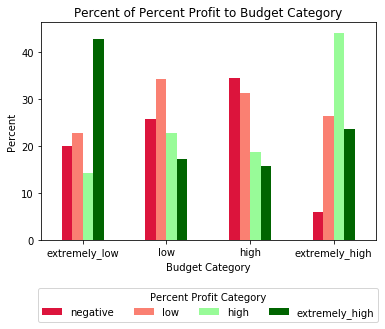%0A)

In \[63\]:

    '''This graph proved very interesting. Movies with an extremely low budget have the highest percentage make-up of making an extremely 
    high percent profit. Movies with an extremely high budget are the most likely to be profitable overall, being that they 
    are the least likely to have a negative profit, with only 5.9% of the movies classified as having an extremely high 
    budget in our dataset made a negative profit. Movies with an low or high budget only make an extremely high 
    percent profit less than 17.1% and 15.6% of the time respectively. They also have the highest chance of making a low or 
    negative profit out of all of the budget categories. Based, on this analysis, percent profits are not uniformally 
    distributed across budget levels. Movies with an extremely high budget are the least likely to have a negative percent 
    profit. Movies with an extremely low budget are the most likely to have an extremely high percent profit. Our 
    recommendation to studios, would be to either have a extremely low or extremely high budget and to veer away from 
    productions with an extremely low or high budget. Further analysis for tighter recommendatios is needed.
    '''

Out\[63\]:

    'This graph proved very interesting. Movies with an extremely low budget have the highest percentage make-up of making an extremely \nhigh percent profit. Movies with an extremely high budget are the most likely to be profitable overall, being that they \nare the least likely to have a negative profit, with only 5.9% of the movies classified as having an extremely high \nbudget in our dataset made a negative profit. Movies with an low or high budget only make an extremely high \npercent profit less than 17.1% and 15.6% of the time respectively. They also have the highest chance of making a low or \nnegative profit out of all of the budget categories. Based, on this analysis, percent profits are not uniformally \ndistributed across budget levels. Movies with an extremely high budget are the least likely to have a negative percent \nprofit. Movies with an extremely low budget are the most likely to have an extremely high percent profit. Our \nrecommendation to studios, would be to either have a extremely low or extremely high budget and to veer away from \nproductions with an extremely low or high budget. Further analysis for tighter recommendatios is needed.\n'

In \[76\]:

    #Question: Do big name production companies impact the percent profit? 

    #To answer this question we are first going to create a for loop that will loop through the production_companies column 
    #in order movies_discretized_df and store the production company in a list called production_company. The only issue 
    #with this method, is that if a movie has more than one production company this will not be shown and only the last 
    #company included in the for loop will be given credit. 

    production_company = []
    for movie in movies_discretized_df['production_companies']:
        if "Universal" in movie:
            production_company.append("Universal")
        elif "Sony" in movie: 
            production_company.append("Sony")
        elif "Fox" in movie: 
            production_company.append("Fox")
        elif "DreamWorks" in movie: 
            production_company.append("DW")
        elif "MGM" in movie: 
            production_company.append("MGM")
        elif "Paramount" in movie: 
            production_company.append("Paramount")
        elif "Disney" in movie: 
            production_company.append("Disney")
        elif "Warner Bros" in movie:
            production_company.append("WB")
        else:
            production_company.append("None")

In \[77\]:

    #Saving the list created by our for loop in a new column in our moview_discretized_df called main_production_co
    movies_discretized_df["main_production_co"] = production_company

In \[78\]:

    movies_discretized_df

Out\[78\]:

|     | title                                       | budget          | genres                                             | production\_companies                               | revenue         | profit          | popularity      | vote\_average   | vote\_count     | month | year | percent\_profit | week    | main\_production\_co |
|-----|---------------------------------------------|-----------------|----------------------------------------------------|-----------------------------------------------------|-----------------|-----------------|-----------------|-----------------|-----------------|-------|------|-----------------|---------|----------------------|
| 1   | Aquaman                                     | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | extremely\_high | extremely\_high | extremely\_high | high            | extremely\_high | 12    | 2018 | extremely\_high | week\_1 | WB                   |
| 3   | Spider-Man: Into the Spider-Verse           | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 12    | 2018 | high            | week\_1 | Sony                 |
| 4   | Bohemian Rhapsody                           | high            | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 10    | 2018 | extremely\_high | week\_4 | Fox                  |
| 6   | Avengers: Infinity War                      | extremely\_high | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 4     | 2018 | extremely\_high | week\_4 | None                 |
| 8   | Hereditary                                  | extremely\_low  | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | high            | high            | extremely\_high | high            | extremely\_high | 6     | 2018 | extremely\_high | week\_1 | None                 |
| 9   | Fantastic Beasts: The Crimes of Grindelwald | extremely\_high | \[{'id': 12, 'name': 'Adventure'}, {'id': 14, '... | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | extremely\_high | extremely\_high | extremely\_high | high            | extremely\_high | 11    | 2018 | high            | week\_2 | WB                   |
| 10  | The Favourite                               | low             | \[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name... | \[{'id': 22842, 'logo\_path': '/waIZoO3pnB0VVCUV... | high            | high            | extremely\_high | extremely\_high | high            | 11    | 2018 | extremely\_high | week\_4 | Fox                  |
| 11  | A Star Is Born                              | high            | \[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n... | \[{'id': 3528, 'logo\_path': '/cCzCClIzIh81Fa79h... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 10    | 2018 | extremely\_high | week\_1 | WB                   |
| 12  | A Simple Favor                              | low             | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 61791, 'logo\_path': '/f72ubyCeowgOQO7n... | low             | high            | extremely\_high | high            | high            | 8     | 2018 | high            | week\_4 | None                 |
| 13  | Crazy Rich Asians                           | low             | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 5420, 'logo\_path': '/dlW4Kh5dNieKNURny... | extremely\_high | extremely\_high | low             | extremely\_high | high            | 8     | 2018 | extremely\_high | week\_2 | WB                   |
| 14  | Mission: Impossible - Fallout               | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 4, 'logo\_path': '/fycMZt242LVjagMByZOL... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 7     | 2018 | high            | week\_2 | Paramount            |
| 15  | Widows                                      | high            | \[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name... | \[{'id': 10104, 'logo\_path': '/hNuGhsKVlmhnwSRc... | high            | high            | high            | low             | low             | 11    | 2018 | low             | week\_1 | None                 |
| 16  | Bad Times at the El Royale                  | high            | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 25, 'logo\_path': '/qZCc1lty5FzX30aOCVR... | low             | negative        | high            | high            | high            | 10    | 2018 | negative        | week\_1 | Fox                  |
| 17  | Mary Poppins Returns                        | extremely\_high | \[{'id': 14, 'name': 'Fantasy'}, {'id': 10751, ... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | extremely\_high | extremely\_high | extremely\_high | high            | high            | 12    | 2018 | high            | week\_2 | Disney               |
| 18  | Green Book                                  | low             | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 6735, 'logo\_path': '/6yyByQrmTAgJv0QzZ... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 11    | 2018 | extremely\_high | week\_3 | Universal            |
| 19  | Deadpool 2                                  | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam... | \[{'id': 7505, 'logo\_path': '/837VMM4wOkODc1idN... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 5     | 2018 | extremely\_high | week\_2 | Fox                  |
| 20  | First Man                                   | extremely\_high | \[{'id': 36, 'name': 'History'}, {'id': 18, 'na... | \[{'id': 7, 'logo\_path': '/vru2SssLX3FPhnKZGtYw... | high            | high            | extremely\_high | extremely\_high | extremely\_high | 10    | 2018 | low             | week\_2 | Universal            |
| 22  | Black Panther                               | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 2     | 2018 | extremely\_high | week\_2 | Disney               |
| 23  | Venom                                       | extremely\_high | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 31828, 'logo\_path': None, 'name': 'Avi... | extremely\_high | extremely\_high | extremely\_high | high            | extremely\_high | 9     | 2018 | extremely\_high | week\_4 | None                 |
| 24  | A Quiet Place                               | low             | \[{'id': 27, 'name': 'Horror'}, {'id': 18, 'nam... | \[{'id': 29312, 'logo\_path': None, 'name': 'Sun... | extremely\_high | extremely\_high | high            | extremely\_high | extremely\_high | 4     | 2018 | extremely\_high | week\_1 | Paramount            |
| 25  | BlacKkKlansman                              | low             | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 3172, 'logo\_path': '/kDedjRZwO8uyFhuHa... | low             | high            | high            | extremely\_high | extremely\_high | 7     | 2018 | high            | week\_4 | None                 |
| 27  | Red Sparrow                                 | extremely\_high | \[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '... | \[{'id': 99426, 'logo\_path': None, 'name': 'Sou... | high            | high            | low             | low             | extremely\_high | 2     | 2018 | high            | week\_4 | Fox                  |
| 28  | Ralph Breaks the Internet                   | extremely\_high | \[{'id': 10751, 'name': 'Family'}, {'id': 16, '... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 11    | 2018 | high            | week\_3 | Disney               |
| 29  | Suspiria                                    | low             | \[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam... | \[{'id': 10989, 'logo\_path': None, 'name': 'Mus... | extremely\_low  | negative        | low             | high            | low             | 10    | 2018 | negative        | week\_2 | None                 |
| 31  | Ready Player One                            | extremely\_high | \[{'id': 12, 'name': 'Adventure'}, {'id': 878, ... | \[{'id': 56, 'logo\_path': '/cEaxANEisCqeEoRvODv... | extremely\_high | extremely\_high | extremely\_high | extremely\_high | extremely\_high | 3     | 2018 | high            | week\_4 | WB                   |
| 32  | The Mule                                    | high            | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 81121, 'logo\_path': '/yX4flP3T5bZuOQ8Q... | high            | high            | extremely\_high | high            | high            | 12    | 2018 | high            | week\_2 | WB                   |
| 33  | Overlord                                    | high            | \[{'id': 27, 'name': 'Horror'}, {'id': 10752, '... | \[{'id': 11461, 'logo\_path': '/p9FoEt5shEKRWRKV... | low             | low             | high            | high            | low             | 11    | 2018 | low             | week\_1 | Paramount            |
| 34  | The Spy Who Dumped Me                       | high            | \[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam... | \[{'id': 23, 'logo\_path': '/mkxNjThahj5pvntvYKV... | low             | negative        | high            | low             | low             | 8     | 2018 | negative        | week\_1 | None                 |
| 35  | Annihilation                                | high            | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 284, 'logo\_path': None, 'name': 'DNA F... | low             | low             | high            | low             | extremely\_high | 2     | 2018 | low             | week\_3 | Paramount            |
| 36  | Solo: A Star Wars Story                     | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 1, 'logo\_path': '/o86DbpburjxrqAzEDhXZ... | extremely\_high | extremely\_high | extremely\_high | high            | extremely\_high | 5     | 2018 | low             | week\_2 | Disney               |
| ... | ...                                         | ...             | ...                                                | ...                                                 | ...             | ...             | ...             | ...             | ...             | ...   | ...  | ...             | ...     | ...                  |
| 188 | The 15:17 to Paris                          | low             | \[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name... | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | low             | low             | extremely\_low  | extremely\_low  | low             | 2     | 2018 | low             | week\_1 | WB                   |
| 196 | Insidious: The Last Key                     | extremely\_low  | \[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '... | \[{'id': 11341, 'logo\_path': '/xytTBODEy3p20ksH... | high            | extremely\_high | low             | low             | high            | 1     | 2018 | extremely\_high | week\_1 | Sony                 |
| 199 | Unsane                                      | extremely\_low  | \[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam... | \[{'id': 508, 'logo\_path': '/7PzJdsLGlR7oW4J0J5... | extremely\_low  | low             | extremely\_low  | low             | low             | 2     | 2018 | extremely\_high | week\_3 | Universal            |
| 201 | Peter Rabbit                                | high            | \[{'id': 16, 'name': 'Animation'}, {'id': 12, '... | \[{'id': 2251, 'logo\_path': '/6l16UFSkZ1oPpyBYa... | extremely\_high | extremely\_high | extremely\_low  | low             | low             | 2     | 2018 | extremely\_high | week\_1 | Sony                 |
| 203 | Siberia                                     | extremely\_low  | \[{'id': 80, 'name': 'Crime'}, {'id': 10749, 'n... | \[{'id': 11517, 'logo\_path': '/7tT0PqNjEalEwE1G... | extremely\_low  | low             | extremely\_low  | extremely\_low  | extremely\_low  | 7     | 2018 | low             | week\_2 | None                 |
| 204 | Gotti                                       | extremely\_low  | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 73685, 'logo\_path': None, 'name': 'Emm... | extremely\_low  | negative        | extremely\_low  | extremely\_low  | extremely\_low  | 6     | 2018 | negative        | week\_2 | None                 |
| 207 | Every Day                                   | extremely\_low  | \[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name... | \[{'id': 85510, 'logo\_path': None, 'name': 'Fil... | extremely\_low  | low             | extremely\_low  | high            | low             | 2     | 2018 | low             | week\_3 | None                 |
| 210 | Action Point                                | low             | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 6328, 'logo\_path': None, 'name': 'Dick... | extremely\_low  | negative        | extremely\_low  | extremely\_low  | extremely\_low  | 6     | 2018 | negative        | week\_1 | Paramount            |
| 211 | Super Troopers 2                            | low             | \[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam... | \[{'id': 2773, 'logo\_path': '/ubyU2v6XcREGwyeie... | extremely\_low  | low             | low             | extremely\_low  | extremely\_low  | 4     | 2018 | low             | week\_3 | Fox                  |
| 219 | Kin                                         | low             | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 2575, 'logo\_path': '/9YJrHYlcfHtwtulkF... | extremely\_low  | negative        | extremely\_low  | low             | extremely\_low  | 8     | 2018 | negative        | week\_4 | None                 |
| 220 | The Miseducation of Cameron Post            | extremely\_low  | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 56403, 'logo\_path': '/uXT3YDtWe3lvMull... | extremely\_low  | low             | extremely\_low  | extremely\_high | extremely\_low  | 7     | 2018 | low             | week\_3 | None                 |
| 225 | Winchester                                  | extremely\_low  | \[{'id': 14, 'name': 'Fantasy'}, {'id': 9648, '... | \[{'id': 96645, 'logo\_path': None, 'name': 'Ima... | low             | low             | low             | extremely\_low  | low             | 2     | 2018 | extremely\_high | week\_1 | None                 |
| 226 | Uncle Drew                                  | low             | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 1632, 'logo\_path': '/cisLn1YAUuptXVBa0... | extremely\_low  | negative        | extremely\_low  | low             | extremely\_low  | 6     | 2018 | negative        | week\_4 | None                 |
| 228 | American Animals                            | extremely\_low  | \[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name... | \[{'id': 6705, 'logo\_path': '/5uoaxZCSYuc6KEiJg... | extremely\_low  | negative        | extremely\_low  | high            | extremely\_low  | 6     | 2018 | negative        | week\_1 | None                 |
| 237 | Blaze                                       | extremely\_low  | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 97085, 'logo\_path': None, 'name': 'Ans... | extremely\_low  | negative        | extremely\_low  | extremely\_high | extremely\_low  | 8     | 2018 | negative        | week\_3 | None                 |
| 253 | The Strangers: Prey at Night                | extremely\_low  | \[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam... | \[{'id': 63443, 'logo\_path': '/iKm40tfw3Hxaz7mU... | low             | low             | extremely\_low  | extremely\_low  | low             | 3     | 2018 | low             | week\_1 | Universal            |
| 255 | Acrimony                                    | low             | \[{'id': 53, 'name': 'Thriller'}\]                 | \[{'id': 3096, 'logo\_path': '/fkZTZ4veYYr3lwr2r... | low             | low             | extremely\_low  | high            | extremely\_low  | 3     | 2018 | low             | week\_4 | None                 |
| 259 | Sherlock Gnomes                             | high            | \[{'id': 10749, 'name': 'Romance'}, {'id': 16, ... | \[{'id': 28320, 'logo\_path': '/5UPGj1MwzrtxclRG... | high            | low             | low             | extremely\_low  | extremely\_low  | 3     | 2018 | low             | week\_2 | Paramount            |
| 261 | Unfriended: Dark Web                        | extremely\_low  | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 33, 'logo\_path': '/8lvHyhjr8oUKOOy2dKX... | extremely\_low  | low             | extremely\_low  | low             | extremely\_low  | 7     | 2018 | extremely\_high | week\_3 | Universal            |
| 269 | Teen Titans Go! To the Movies               | extremely\_low  | \[{'id': 16, 'name': 'Animation'}, {'id': 28, '... | \[{'id': 2785, 'logo\_path': '/l5zW8jjmQOCx2dFmv... | low             | low             | extremely\_low  | high            | extremely\_low  | 7     | 2018 | high            | week\_4 | WB                   |
| 275 | Breaking In                                 | extremely\_low  | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 49968, 'logo\_path': '/d74xevT5HfJN1TOD... | low             | high            | extremely\_low  | extremely\_low  | extremely\_low  | 5     | 2018 | extremely\_high | week\_1 | None                 |
| 280 | The Hurricane Heist                         | high            | \[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam... | \[{'id': 100849, 'logo\_path': None, 'name': 'Wi... | extremely\_low  | negative        | high            | extremely\_low  | low             | 2     | 2018 | negative        | week\_4 | None                 |
| 289 | SuperFly                                    | low             | \[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | extremely\_low  | low             | extremely\_low  | low             | extremely\_low  | 6     | 2018 | low             | week\_2 | Sony                 |
| 290 | Traffik                                     | extremely\_low  | \[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n... | \[{'id': 102809, 'logo\_path': None, 'name': 'Hi... | extremely\_low  | low             | extremely\_low  | extremely\_low  | extremely\_low  | 4     | 2018 | low             | week\_3 | None                 |
| 321 | Kickboxer: Retaliation                      | extremely\_low  | \[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam... | \[\]                                                | extremely\_low  | negative        | low             | extremely\_low  | extremely\_low  | 1     | 2018 | negative        | week\_4 | None                 |
| 331 | Paul, Apostle of Christ                     | extremely\_low  | \[{'id': 36, 'name': 'History'}\]                  | \[{'id': 81520, 'logo\_path': None, 'name': 'Out... | low             | low             | extremely\_low  | high            | extremely\_low  | 3     | 2018 | high            | week\_4 | None                 |
| 332 | Early Man                                   | high            | \[{'id': 10751, 'name': 'Family'}, {'id': 35, '... | \[{'id': 297, 'logo\_path': '/ykJbf1z5qIreJrHWfn... | low             | low             | extremely\_low  | extremely\_low  | extremely\_low  | 1     | 2018 | low             | week\_4 | None                 |
| 336 | Hearts Beat Loud                            | extremely\_low  | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 18346, 'logo\_path': '/vRQOTOMEohkoIfPN... | extremely\_low  | low             | extremely\_low  | extremely\_high | extremely\_low  | 6     | 2018 | low             | week\_1 | None                 |
| 398 | Proud Mary                                  | low             | \[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n... | \[{'id': 3287, 'logo\_path': '/bz6GbCQQXGNE56LTW... | low             | low             | extremely\_low  | extremely\_low  | extremely\_low  | 1     | 2018 | low             | week\_2 | None                 |
| 427 | Show Dogs                                   | extremely\_low  | \[{'id': 12, 'name': 'Adventure'}, {'id': 80, '... | \[{'id': 76314, 'logo\_path': '/oFiHo3350Nj7bi6o... | low             | high            | extremely\_low  | extremely\_low  | extremely\_low  | 5     | 2018 | extremely\_high | week\_2 | None                 |

136 rows × 14 columns

In \[81\]:

    #Now we want to group by production company and percent profit 
    '''We want to compare the production company percentage make up for each percent_profit level. To do this we need to 
    get the count for each production company, the count for each percent_profit level by production company and then divide 
    the count of the percent_profit/count of production company and multiply by 100. We have to do this for each 
    production company and level of percent_profits. We think that we could potentially answer this question by group bys.'''
    movies_discretized_count_q2 = movies_discretized_df.groupby(["main_production_co", "percent_profit"])["main_production_co"].count()
    '''Taking the output from the line above and converting it to a data frame. We are using pandas, which we important as pd. 
    First, we call the package we are using then the function from that package and then what we want to run the function on.
    pd.function(item to use). We are using the DataFrame function from the pandas package on the series created by our group by'''
    movies_discretized_count_df_q2 = pd.DataFrame(movies_discretized_count_q2)
    #Checking to see what our df looks like. 
    movies_discretized_count_df_q2
    #Changing the column name from budget to counts
    movies_discretized_count_df_q2.columns = ["counts"]
    #Checking to see what our df looks like. 
    movies_discretized_count_df_q2

Out\[81\]:

counts

main\_production\_co

percent\_profit

DW

negative

1

Disney

negative

1

low

3

high

2

extremely\_high

2

Fox

negative

1

low

4

high

3

extremely\_high

3

None

negative

22

low

17

high

13

extremely\_high

14

Paramount

negative

2

low

4

high

2

extremely\_high

1

Sony

negative

1

low

3

high

2

extremely\_high

2

Universal

negative

1

low

6

high

4

extremely\_high

9

WB

low

2

high

8

extremely\_high

3

In \[82\]:

    #We want to get a total count for the number of percent_profit counts for each production company.
    '''This shows that we have 2 indexes budget and percent_profit... We want to create columns from each index
    We are creating a new column named budget by extracting the values from the first index (0) which is the budget
    index'''
    movies_discretized_count_df_q2["production_company"]=movies_discretized_count_df_q2.index.get_level_values(0)
    #We are creating a new column named total_donations by extracting the values from the second index (1) which is total_donations
    movies_discretized_count_df_q2["percent_profit_category"] = movies_discretized_count_df_q2.index.get_level_values(1)
    #Checking to make sure it worked... 
    movies_discretized_count_df_q2
    #It did! 

Out\[82\]:

counts

production\_company

percent\_profit\_category

main\_production\_co

percent\_profit

DW

negative

1

DW

negative

Disney

negative

1

Disney

negative

low

3

Disney

low

high

2

Disney

high

extremely\_high

2

Disney

extremely\_high

Fox

negative

1

Fox

negative

low

4

Fox

low

high

3

Fox

high

extremely\_high

3

Fox

extremely\_high

None

negative

22

None

negative

low

17

None

low

high

13

None

high

extremely\_high

14

None

extremely\_high

Paramount

negative

2

Paramount

negative

low

4

Paramount

low

high

2

Paramount

high

extremely\_high

1

Paramount

extremely\_high

Sony

negative

1

Sony

negative

low

3

Sony

low

high

2

Sony

high

extremely\_high

2

Sony

extremely\_high

Universal

negative

1

Universal

negative

low

6

Universal

low

high

4

Universal

high

extremely\_high

9

Universal

extremely\_high

WB

low

2

WB

low

high

8

WB

high

extremely\_high

3

WB

extremely\_high

In \[84\]:

    #Now we want to remove the indexes so, we can create a new group by to get the sum of the counts for each group 
    #To do this we are using the reset_index(drop = True) This will drop our group by indexes and allow us to create a new one. 
    movies_discretized_count_df_q2 = movies_discretized_count_df_q2.reset_index(drop = True)

In \[85\]:

    #Now we are getting the sum of each production company category. 
    production_company_discretized_count_df_q2 = movies_discretized_count_df_q2.groupby(["production_company"])["counts"].sum()

In \[87\]:

    #Checking the results
    production_company_discretized_count_df_q2

Out\[87\]:

    production_company
    DW            1
    Disney        8
    Fox          11
    None         66
    Paramount     9
    Sony          8
    Universal    20
    WB           13
    Name: counts, dtype: int64

In \[89\]:

    '''We ultimately want a column that contains the total counts for each production company. We are going to create 
    a new column that replicates the production company called production_company_count and then we will use the replace function to 
    replace the 1s with their total count, the 2s with their total count... '''
    #First, replicating the income level column in a column named budget_category_count
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company"] 
    #Now replacing the income level with the total count for each income level 
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["DW"], 1)
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["Disney"], 8)
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["Fox"], 11)
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["None"], 66)
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["Paramount"], 9)
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["Sony"], 8)
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["Universal"], 20)
    movies_discretized_count_df_q2["production_company_count"] = movies_discretized_count_df_q2["production_company_count"].replace(["WB"], 13)

In \[90\]:

    movies_discretized_count_df_q2

Out\[90\]:

|     | counts | production\_company | percent\_profit\_category | production\_company\_count |
|-----|--------|---------------------|---------------------------|----------------------------|
| 0   | 1      | DW                  | negative                  | 1                          |
| 1   | 1      | Disney              | negative                  | 8                          |
| 2   | 3      | Disney              | low                       | 8                          |
| 3   | 2      | Disney              | high                      | 8                          |
| 4   | 2      | Disney              | extremely\_high           | 8                          |
| 5   | 1      | Fox                 | negative                  | 11                         |
| 6   | 4      | Fox                 | low                       | 11                         |
| 7   | 3      | Fox                 | high                      | 11                         |
| 8   | 3      | Fox                 | extremely\_high           | 11                         |
| 9   | 22     | None                | negative                  | 66                         |
| 10  | 17     | None                | low                       | 66                         |
| 11  | 13     | None                | high                      | 66                         |
| 12  | 14     | None                | extremely\_high           | 66                         |
| 13  | 2      | Paramount           | negative                  | 9                          |
| 14  | 4      | Paramount           | low                       | 9                          |
| 15  | 2      | Paramount           | high                      | 9                          |
| 16  | 1      | Paramount           | extremely\_high           | 9                          |
| 17  | 1      | Sony                | negative                  | 8                          |
| 18  | 3      | Sony                | low                       | 8                          |
| 19  | 2      | Sony                | high                      | 8                          |
| 20  | 2      | Sony                | extremely\_high           | 8                          |
| 21  | 1      | Universal           | negative                  | 20                         |
| 22  | 6      | Universal           | low                       | 20                         |
| 23  | 4      | Universal           | high                      | 20                         |
| 24  | 9      | Universal           | extremely\_high           | 20                         |
| 25  | 2      | WB                  | low                       | 13                         |
| 26  | 8      | WB                  | high                      | 13                         |
| 27  | 3      | WB                  | extremely\_high           | 13                         |

In \[91\]:

    #Okay, we are one step closer... Now, we need to create a column that takes the counts/budget_category_counts * 100 
    movies_discretized_count_df_q2["percent"] = movies_discretized_count_df_q2["counts"]/movies_discretized_count_df_q2["production_company_count"] *100

In \[92\]:

    #Looking at our data frame... It worked!!! 
    movies_discretized_count_df_q2

Out\[92\]:

|     | counts | production\_company | percent\_profit\_category | production\_company\_count | percent    |
|-----|--------|---------------------|---------------------------|----------------------------|------------|
| 0   | 1      | DW                  | negative                  | 1                          | 100.000000 |
| 1   | 1      | Disney              | negative                  | 8                          | 12.500000  |
| 2   | 3      | Disney              | low                       | 8                          | 37.500000  |
| 3   | 2      | Disney              | high                      | 8                          | 25.000000  |
| 4   | 2      | Disney              | extremely\_high           | 8                          | 25.000000  |
| 5   | 1      | Fox                 | negative                  | 11                         | 9.090909   |
| 6   | 4      | Fox                 | low                       | 11                         | 36.363636  |
| 7   | 3      | Fox                 | high                      | 11                         | 27.272727  |
| 8   | 3      | Fox                 | extremely\_high           | 11                         | 27.272727  |
| 9   | 22     | None                | negative                  | 66                         | 33.333333  |
| 10  | 17     | None                | low                       | 66                         | 25.757576  |
| 11  | 13     | None                | high                      | 66                         | 19.696970  |
| 12  | 14     | None                | extremely\_high           | 66                         | 21.212121  |
| 13  | 2      | Paramount           | negative                  | 9                          | 22.222222  |
| 14  | 4      | Paramount           | low                       | 9                          | 44.444444  |
| 15  | 2      | Paramount           | high                      | 9                          | 22.222222  |
| 16  | 1      | Paramount           | extremely\_high           | 9                          | 11.111111  |
| 17  | 1      | Sony                | negative                  | 8                          | 12.500000  |
| 18  | 3      | Sony                | low                       | 8                          | 37.500000  |
| 19  | 2      | Sony                | high                      | 8                          | 25.000000  |
| 20  | 2      | Sony                | extremely\_high           | 8                          | 25.000000  |
| 21  | 1      | Universal           | negative                  | 20                         | 5.000000   |
| 22  | 6      | Universal           | low                       | 20                         | 30.000000  |
| 23  | 4      | Universal           | high                      | 20                         | 20.000000  |
| 24  | 9      | Universal           | extremely\_high           | 20                         | 45.000000  |
| 25  | 2      | WB                  | low                       | 13                         | 15.384615  |
| 26  | 8      | WB                  | high                      | 13                         | 61.538462  |
| 27  | 3      | WB                  | extremely\_high           | 13                         | 23.076923  |

In \[93\]:

    #We no longer need the count columns
    movies_discretized_count_df_q2.drop(["counts", "production_company_count"], axis = 1, inplace = True )

In \[94\]:

    '''Attempting to graph this data using a grouped bar chart: 
    formula: df.pivot(columns, group, values).plot(kind = "type of graph", color = ["color to use, can be a list of colors"], 
    title = "you can set the title of your graph here")'''
    graph = movies_discretized_count_df_q2.pivot("production_company", "percent_profit_category", 
                                                    "percent").plot(kind="bar", color = ["crimson", "salmon", "palegreen", "darkgreen"], 
                                                                   title = "Percent of Percent Profit to Production Company")
    #Changing the y label of our graph to Percent
    plt.ylabel("Percent")
    #Changing the x axis label of our graph to Budget Category 
    plt.xlabel("Production Company")
    #Making it so the tick labels are not angled 
    plt.xticks(rotation = 0)
    #How to change the tick labels (we ended up not needing this, but want to keep for future reference)
    #plt.Axes.set_xticklabels(graph, labels = ['extremely low', 'low', 'high', 'extremely high'])
    #moving the legend position to underneath the graph, also setting it to have 4 columns so the legend is in a 
    #straight single line and adding a legend title
    plt.legend( loc = "lower center", bbox_to_anchor = (.5, -.4), ncol = 4, title = "Percent Profit Category")

Out\[94\]:

    <matplotlib.legend.Legend at 0x2bf78ebdf28>

![](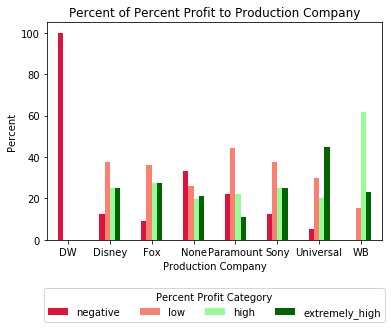%0A)

In \[ \]:

    '''This graph provides some insights, however, most of our movies have more than one main production company and only 
    one production company is being shown. For example, DreamWorks and Universal had a movie named First Man and it was 
    profitable. However, based on the way that we assigned a main production company, only Universal was given credit for 
    that movie.'''

In \[108\]:

    # Question: 
    #Does time of the month the movie is released affect percent profit? 
    '''We want to compare the percent_profit level percentage make up for each time of month. To do this we need to 
    get the count for each time of month, the count for each percent_profit level by time of month company and then divide 
    the count of the percent_profit/count of time of month and multiply by 100. We have to do this for each 
    time of month and level of percent_profits.'''
    movies_discretized_count_q3 = movies_discretized_df.groupby(["week", "percent_profit"])["week"].count()
    '''Taking the output from the line above and converting it to a data frame. We are using pandas, which we important as pd. 
    First, we call the package we are using then the function from that package and then what we want to run the function on.
    pd.function(item to use). We are using the DataFrame function from the pandas package on the series created by our group by'''
    movies_discretized_count_df_q3 = pd.DataFrame(movies_discretized_count_q3)
    #Checking to see what our df looks like. 
    movies_discretized_count_df_q3
    #Changing the column name from week to counts
    movies_discretized_count_df_q3.columns = ["counts"]
    #Checking to see what our df looks like. 
    movies_discretized_count_df_q3

Out\[108\]:

counts

week

percent\_profit

week\_1

negative

5

low

13

high

5

extremely\_high

14

week\_2

negative

5

low

9

high

13

extremely\_high

7

week\_3

negative

9

low

10

high

6

extremely\_high

8

week\_4

negative

10

low

7

high

10

extremely\_high

5

In \[109\]:

    #We want to get a total count for the number of percent_profit counts for each week.
    '''This shows that we have 2 indexes week and percent_profit... We want to create columns from each index
    We are creating a new column named week by extracting the values from the first index (0) which is the week
    index'''
    movies_discretized_count_df_q3["week"]=movies_discretized_count_df_q3.index.get_level_values(0)
    #We are creating a new column named total_donations by extracting the values from the second index (1) which is percent_profit
    movies_discretized_count_df_q3["percent_profit_category"] = movies_discretized_count_df_q3.index.get_level_values(1)
    #Checking to make sure it worked... 
    movies_discretized_count_df_q3
    #It did! 

Out\[109\]:

counts

week

percent\_profit\_category

week

percent\_profit

week\_1

negative

5

week\_1

negative

low

13

week\_1

low

high

5

week\_1

high

extremely\_high

14

week\_1

extremely\_high

week\_2

negative

5

week\_2

negative

low

9

week\_2

low

high

13

week\_2

high

extremely\_high

7

week\_2

extremely\_high

week\_3

negative

9

week\_3

negative

low

10

week\_3

low

high

6

week\_3

high

extremely\_high

8

week\_3

extremely\_high

week\_4

negative

10

week\_4

negative

low

7

week\_4

low

high

10

week\_4

high

extremely\_high

5

week\_4

extremely\_high

In \[110\]:

    #Now we want to remove the indexes so, we can create a new group by to get the sum of the counts for each group 
    #To do this we are using the reset_index(drop = True) This will drop our group by indexes and allow us to create a new one. 
    movies_discretized_count_df_q3 = movies_discretized_count_df_q3.reset_index(drop = True)

In \[107\]:

     

Out\[107\]:

|     | title             | budget | genres                                             | production\_companies                               | revenue        | profit   | popularity | vote\_average | vote\_count    | month | year | percent\_profit | week    | main\_production\_co |
|-----|-------------------|--------|----------------------------------------------------|-----------------------------------------------------|----------------|----------|------------|---------------|----------------|-------|------|-----------------|---------|----------------------|
| 132 | Welcome to Marwen | high   | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 7, 'logo\_path': '/vru2SssLX3FPhnKZGtYw... | extremely\_low | negative | high       | low           | extremely\_low | 12    | 2018 | negative        | week\_3 | DW                   |

In \[111\]:

    #Now we are getting the sum of each production company category. 
    week_discretized_count_df_q3 = movies_discretized_count_df_q3.groupby(["week"])["counts"].sum()

In \[113\]:

    #Checking the results
    week_discretized_count_df_q3

Out\[113\]:

    week
    week_1    37
    week_2    34
    week_3    33
    week_4    32
    Name: counts, dtype: int64

In \[114\]:

    '''We ultimately want a column that contains the total counts for each week. We are going to create 
    a new column that replicates the week called week_count and then we will use the replace function to 
    replace the 1s with their total count, the 2s with their total count... '''
    #First, replicating the income level column in a column named budget_category_count
    movies_discretized_count_df_q3["week_count"] = movies_discretized_count_df_q3["week"] 
    #Now replacing the income level with the total count for each income level 
    movies_discretized_count_df_q3["week_count"] = movies_discretized_count_df_q3["week_count"].replace(["week_1"], 37)
    movies_discretized_count_df_q3["week_count"] = movies_discretized_count_df_q3["week_count"].replace(["week_2"], 34)
    movies_discretized_count_df_q3["week_count"] = movies_discretized_count_df_q3["week_count"].replace(["week_3"], 33)
    movies_discretized_count_df_q3["week_count"] = movies_discretized_count_df_q3["week_count"].replace(["week_4"], 32)

In \[115\]:

    movies_discretized_count_df_q3

Out\[115\]:

|     | counts | week    | percent\_profit\_category | week\_count |
|-----|--------|---------|---------------------------|-------------|
| 0   | 5      | week\_1 | negative                  | 37          |
| 1   | 13     | week\_1 | low                       | 37          |
| 2   | 5      | week\_1 | high                      | 37          |
| 3   | 14     | week\_1 | extremely\_high           | 37          |
| 4   | 5      | week\_2 | negative                  | 34          |
| 5   | 9      | week\_2 | low                       | 34          |
| 6   | 13     | week\_2 | high                      | 34          |
| 7   | 7      | week\_2 | extremely\_high           | 34          |
| 8   | 9      | week\_3 | negative                  | 33          |
| 9   | 10     | week\_3 | low                       | 33          |
| 10  | 6      | week\_3 | high                      | 33          |
| 11  | 8      | week\_3 | extremely\_high           | 33          |
| 12  | 10     | week\_4 | negative                  | 32          |
| 13  | 7      | week\_4 | low                       | 32          |
| 14  | 10     | week\_4 | high                      | 32          |
| 15  | 5      | week\_4 | extremely\_high           | 32          |

In \[116\]:

    #Okay, we are one step closer... Now, we need to create a column that takes the counts/week_count * 100 
    movies_discretized_count_df_q3["percent"] = movies_discretized_count_df_q3["counts"]/movies_discretized_count_df_q3["week_count"] *100

In \[117\]:

    #Looking at our data frame... It worked!!! 
    movies_discretized_count_df_q3

Out\[117\]:

|     | counts | week    | percent\_profit\_category | week\_count | percent   |
|-----|--------|---------|---------------------------|-------------|-----------|
| 0   | 5      | week\_1 | negative                  | 37          | 13.513514 |
| 1   | 13     | week\_1 | low                       | 37          | 35.135135 |
| 2   | 5      | week\_1 | high                      | 37          | 13.513514 |
| 3   | 14     | week\_1 | extremely\_high           | 37          | 37.837838 |
| 4   | 5      | week\_2 | negative                  | 34          | 14.705882 |
| 5   | 9      | week\_2 | low                       | 34          | 26.470588 |
| 6   | 13     | week\_2 | high                      | 34          | 38.235294 |
| 7   | 7      | week\_2 | extremely\_high           | 34          | 20.588235 |
| 8   | 9      | week\_3 | negative                  | 33          | 27.272727 |
| 9   | 10     | week\_3 | low                       | 33          | 30.303030 |
| 10  | 6      | week\_3 | high                      | 33          | 18.181818 |
| 11  | 8      | week\_3 | extremely\_high           | 33          | 24.242424 |
| 12  | 10     | week\_4 | negative                  | 32          | 31.250000 |
| 13  | 7      | week\_4 | low                       | 32          | 21.875000 |
| 14  | 10     | week\_4 | high                      | 32          | 31.250000 |
| 15  | 5      | week\_4 | extremely\_high           | 32          | 15.625000 |

In \[118\]:

    #We no longer need the count columns
    movies_discretized_count_df_q3.drop(["counts", "week_count"], axis = 1, inplace = True )

In \[119\]:

    '''Attempting to graph this data using a grouped bar chart: 
    formula: df.pivot(columns, group, values).plot(kind = "type of graph", color = ["color to use, can be a list of colors"], 
    title = "you can set the title of your graph here")'''
    graph = movies_discretized_count_df_q3.pivot("week", "percent_profit_category", 
                                                    "percent").plot(kind="bar", color = ["crimson", "salmon", "palegreen", "darkgreen"], 
                                                                   title = "Percent of Percent Profit to Week")
    #Changing the y label of our graph to Percent
    plt.ylabel("Percent")
    #Changing the x axis label of our graph to Budget Category 
    plt.xlabel("Week")
    #Making it so the tick labels are not angled 
    plt.xticks(rotation = 0)
    #How to change the tick labels (we ended up not needing this, but want to keep for future reference)
    #plt.Axes.set_xticklabels(graph, labels = ['extremely low', 'low', 'high', 'extremely high'])
    #moving the legend position to underneath the graph, also setting it to have 4 columns so the legend is in a 
    #straight single line and adding a legend title
    plt.legend( loc = "lower center", bbox_to_anchor = (.5, -.4), ncol = 4, title = "Percent Profit Category")

Out\[119\]:

    <matplotlib.legend.Legend at 0x2bf792d1828>

![](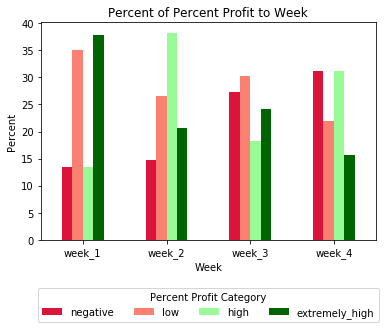%0A)

In \[2\]:

    '''This is interesting in that it shows that movies released within the first two weeks of the month tend to be more 
    profitable. We would like to look at a breakdown of month to percent profit for further analysis'''

Out\[2\]:

    'This is interesting in that it shows that movies released within the first two weeks of the month tend to be more \nprofitable. We would like to look at a breakdown of month to percent profit for further analysis'

In \[4\]:

    # Taking a brief detour back to our non-discretized df
    movies_original_df

Out\[4\]:

|     | release\_date | title                                       | budget          | genres                                             | production\_companies                               | revenue      | profit        | popularity | vote\_average | vote\_count |
|-----|---------------|---------------------------------------------|-----------------|----------------------------------------------------|-----------------------------------------------------|--------------|---------------|------------|---------------|-------------|
| 0   | NaN           | NaN                                         | NaN             | NaN                                                | NaN                                                 | NaN          | NaN           | NaN        | NaN           | NaN         |
| 1   | 2018-12-07    | Aquaman                                     | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 429, 'logo\_path': '/2Tc1P3Ac8M479naPp1... | 1.143689e+09 | 9.836892e+08  | 28.789     | 6.8           | 6781.0      |
| 2   | 2019-08-29    | Night Hunter                                | NaN             | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 109529, 'logo\_path': None, 'name': 'Ar... | 0.000000e+00 | 0.000000e+00  | 48.191     | 0.0           | 13.0        |
| 3   | 2018-12-06    | Spider-Man: Into the Spider-Verse           | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 5, 'logo\_path': '/71BqEFAF4V3qjjMPCpLu... | 3.754504e+08 | 2.854504e+08  | 39.780     | 8.4           | 4808.0      |
| 4   | 2018-10-24    | Bohemian Rhapsody                           | high            | \[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n... | \[{'id': 3281, 'logo\_path': '/8tMybAieh64uzvm8k... | 8.940275e+08 | 8.420275e+08  | 35.534     | 8.1           | 8357.0      |
| 5   | 1985-07-13    | Live Aid                                    | NaN             | \[{'id': 10402, 'name': 'Music'}, {'id': 99, 'n... | \[{'id': 3065, 'logo\_path': '/sJ919bmS8B53hujwb... | 0.000000e+00 | 0.000000e+00  | 2.065      | 7.8           | 23.0        |
| 6   | 2018-04-25    | Avengers: Infinity War                      | extremely\_high | \[{'id': 12, 'name': 'Adventure'}, {'id': 28, '... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 2.046240e+09 | 1.746240e+09  | 71.537     | 8.3           | 14913.0     |
| 7   | 2019-08-15    | Driven                                      | NaN             | \[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n... | \[{'id': 60622, 'logo\_path': None, 'name': 'Tem... | 0.000000e+00 | 0.000000e+00  | 39.114     | 5.7           | 9.0         |
| 8   | 2018-06-07    | Hereditary                                  | extremely\_low  | \[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n... | \[{'id': 24277, 'logo\_path': '/mRSBVNNL2lZvJKVG... | 7.933682e+07 | 6.933682e+07  | 29.333     | 7.0           | 2797.0      |
| 9   | 2018-11-14    | Fantastic Beasts: The Crimes of Grindelwald | extremely\_high | \[{'id': 12, 'name': 'Adventure'}, {'id': 14, '... | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | 6.533559e+08 | 4.533559e+08  | 36.627     | 6.9           | 5320.0      |
| 10  | 2018-11-23    | The Favourite                               | low             | \[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name... | \[{'id': 22842, 'logo\_path': '/waIZoO3pnB0VVCUV... | 8.212480e+07 | 6.712480e+07  | 23.448     | 7.6           | 2387.0      |
| 11  | 2018-10-03    | A Star Is Born                              | high            | \[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n... | \[{'id': 3528, 'logo\_path': '/cCzCClIzIh81Fa79h... | 4.338889e+08 | 3.978889e+08  | 26.058     | 7.5           | 6236.0      |
| 12  | 2018-08-29    | A Simple Favor                              | low             | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 61791, 'logo\_path': '/f72ubyCeowgOQO7n... | 5.354242e+07 | 3.354242e+07  | 23.197     | 6.6           | 1961.0      |
| 13  | 2018-08-15    | Crazy Rich Asians                           | low             | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 5420, 'logo\_path': '/dlW4Kh5dNieKNURny... | 2.379946e+08 | 2.079946e+08  | 15.469     | 7.1           | 1643.0      |
| 14  | 2018-07-13    | Mission: Impossible - Fallout               | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 4, 'logo\_path': '/fycMZt242LVjagMByZOL... | 7.910175e+08 | 6.130175e+08  | 27.676     | 7.3           | 4063.0      |
| 15  | 2018-11-06    | Widows                                      | high            | \[{'id': 80, 'name': 'Crime'}, {'id': 53, 'name... | \[{'id': 10104, 'logo\_path': '/hNuGhsKVlmhnwSRc... | 7.386609e+07 | 3.186609e+07  | 18.947     | 6.5           | 1032.0      |
| 16  | 2018-10-04    | Bad Times at the El Royale                  | high            | \[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n... | \[{'id': 25, 'logo\_path': '/qZCc1lty5FzX30aOCVR... | 3.188272e+07 | -1.172760e+05 | 15.930     | 6.8           | 1606.0      |
| 17  | 2018-12-13    | Mary Poppins Returns                        | extremely\_high | \[{'id': 14, 'name': 'Fantasy'}, {'id': 10751, ... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 3.488071e+08 | 2.188071e+08  | 25.464     | 6.6           | 1655.0      |
| 18  | 2018-11-16    | Green Book                                  | low             | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 6735, 'logo\_path': '/6yyByQrmTAgJv0QzZ... | 3.197000e+08 | 2.967000e+08  | 34.561     | 8.3           | 4029.0      |
| 19  | 2018-05-10    | Deadpool 2                                  | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam... | \[{'id': 7505, 'logo\_path': '/837VMM4wOkODc1idN... | 7.415474e+08 | 6.315474e+08  | 35.220     | 7.5           | 9295.0      |
| 20  | 2018-10-11    | First Man                                   | extremely\_high | \[{'id': 36, 'name': 'History'}, {'id': 18, 'na... | \[{'id': 7, 'logo\_path': '/vru2SssLX3FPhnKZGtYw... | 1.005462e+08 | 3.054615e+07  | 23.927     | 7.1           | 2593.0      |
| 21  | 2019-08-09    | Brian Banks                                 | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 14.553     | 6.0           | 1.0         |
| 22  | 2018-02-13    | Black Panther                               | extremely\_high | \[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam... | \[{'id': 420, 'logo\_path': '/hUzeosd33nzE5MCNsZ... | 1.346739e+09 | 1.146739e+09  | 43.354     | 7.4           | 13019.0     |
| 23  | 2018-09-28    | Venom                                       | extremely\_high | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 31828, 'logo\_path': None, 'name': 'Avi... | 8.550140e+08 | 7.390140e+08  | 34.764     | 6.6           | 6851.0      |
| 24  | 2018-04-03    | A Quiet Place                               | low             | \[{'id': 27, 'name': 'Horror'}, {'id': 18, 'nam... | \[{'id': 29312, 'logo\_path': None, 'name': 'Sun... | 3.406772e+08 | 3.236772e+08  | 20.956     | 7.3           | 6240.0      |
| 25  | 2018-07-30    | BlacKkKlansman                              | low             | \[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name... | \[{'id': 3172, 'logo\_path': '/kDedjRZwO8uyFhuHa... | 4.868660e+07 | 3.368660e+07  | 20.828     | 7.6           | 3484.0      |
| 26  | 2019-07-26    | Skin                                        | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 19640, 'logo\_path': '/p8SE7J23xviBArUL... | 0.000000e+00 | 0.000000e+00  | 16.434     | 7.1           | 32.0        |
| 27  | 2018-02-28    | Red Sparrow                                 | extremely\_high | \[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '... | \[{'id': 99426, 'logo\_path': None, 'name': 'Sou... | 1.479882e+08 | 7.898819e+07  | 14.308     | 6.5           | 3558.0      |
| 28  | 2018-11-20    | Ralph Breaks the Internet                   | extremely\_high | \[{'id': 10751, 'name': 'Family'}, {'id': 16, '... | \[{'id': 2, 'logo\_path': '/wdrCwmRnLFJhEoH8GSfy... | 5.292212e+08 | 3.542212e+08  | 35.588     | 7.2           | 3066.0      |
| 29  | 2018-10-11    | Suspiria                                    | low             | \[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam... | \[{'id': 10989, 'logo\_path': None, 'name': 'Mus... | 6.348889e+06 | -1.365111e+07 | 14.431     | 7.0           | 867.0       |
| ... | ...           | ...                                         | ...             | ...                                                | ...                                                 | ...          | ...           | ...        | ...           | ...         |
| 473 | 2018-03-15    | The Matchmaker's Playbook                   | NaN             | \[{'id': 10749, 'name': 'Romance'}\]               | \[{'id': 92153, 'logo\_path': '/psjvYkjjgAPtS8ut... | 0.000000e+00 | 0.000000e+00  | 3.408      | 6.0           | 11.0        |
| 474 | 2018-08-26    | Marfa Girl 2                                | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 3.725      | 6.0           | 4.0         |
| 475 | 2018-06-20    | The Work Wife                               | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 6679, 'logo\_path': None, 'name': 'MarV... | 0.000000e+00 | 0.000000e+00  | 1.403      | 5.0           | 3.0         |
| 476 | 2018-11-30    | A Christmas Prince: The Royal Wedding       | NaN             | \[{'id': 10749, 'name': 'Romance'}, {'id': 35, ... | \[{'id': 2090, 'logo\_path': '/jYlUttNqcN5u1pzMQ... | 0.000000e+00 | 0.000000e+00  | 8.822      | 6.4           | 441.0       |
| 477 | 2018-11-13    | Nazi Overlord                               | NaN             | \[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam... | \[{'id': 1311, 'logo\_path': '/ic2bTizdzRLDVzAvN... | 0.000000e+00 | 0.000000e+00  | 4.910      | 3.6           | 10.0        |
| 478 | 2018-02-23    | Half Magic                                  | NaN             | \[{'id': 10749, 'name': 'Romance'}, {'id': 35, ... | \[{'id': 56236, 'logo\_path': None, 'name': 'The... | 0.000000e+00 | 0.000000e+00  | 3.622      | 5.5           | 17.0        |
| 479 | 2018-11-08    | Watch If You Dare                           | NaN             | \[{'id': 27, 'name': 'Horror'}\]                   | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.691      | 2.8           | 4.0         |
| 480 | 2018-03-30    | God's Not Dead: A Light in Darkness         | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 79986, 'logo\_path': None, 'name': 'Pur... | 5.728940e+06 | 5.728940e+06  | 6.814      | 6.9           | 50.0        |
| 481 | 2018-05-11    | The Honor List                              | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 2.948      | 6.6           | 11.0        |
| 482 | 2018-01-07    | Dead Sexy                                   | NaN             | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 106003, 'logo\_path': None, 'name': 'Ea... | 0.000000e+00 | 0.000000e+00  | 4.464      | 2.0           | 4.0         |
| 483 | 2018-05-18    | Hurricane Bianca: From Russia with Hate     | NaN             | \[{'id': 35, 'name': 'Comedy'}\]                   | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 5.169      | 5.5           | 85.0        |
| 484 | 2018-10-06    | We the Animals                              | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 12219, 'logo\_path': '/2ddXaM0AHMpAl3tm... | 0.000000e+00 | 0.000000e+00  | 4.963      | 6.8           | 47.0        |
| 485 | 2018-03-11    | Perfect                                     | NaN             | \[{'id': 53, 'name': 'Thriller'}, {'id': 878, '... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.859      | 3.5           | 2.0         |
| 486 | 2018-06-12    | Alex & Me                                   | NaN             | \[{'id': 10751, 'name': 'Family'}\]                | \[{'id': 174, 'logo\_path': '/ky0xOc5OrhzkZ1N6Ky... | 0.000000e+00 | 0.000000e+00  | 3.305      | 7.3           | 34.0        |
| 487 | 2018-04-16    | When Jeff Tried to Save The World           | NaN             | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 96203, 'logo\_path': None, 'name': '71 ... | 0.000000e+00 | 0.000000e+00  | 1.501      | 4.8           | 6.0         |
| 488 | 2019-06-04    | The Odds                                    | NaN             | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 118114, 'logo\_path': None, 'name': 'Up... | 0.000000e+00 | 0.000000e+00  | 2.427      | 6.8           | 4.0         |
| 489 | 2018-04-13    | Sgt. Stubby: An American Hero               | low             | \[{'id': 16, 'name': 'Animation'}, {'id': 12, '... | \[{'id': 112595, 'logo\_path': None, 'name': 'Fu... | 0.000000e+00 | -2.500000e+07 | 5.350      | 6.3           | 14.0        |
| 490 | 2016-09-26    | Unbelievable!!!!!                           | extremely\_low  | \[{'id': 878, 'name': 'Science Fiction'}, {'id'... | \[{'id': 48137, 'logo\_path': None, 'name': 'Arc... | 0.000000e+00 | -2.500000e+06 | 1.141      | 6.0           | 1.0         |
| 491 | 2018-04-28    | Better Start Running                        | NaN             | \[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name... | \[{'id': 4560, 'logo\_path': None, 'name': 'Tunn... | 0.000000e+00 | 0.000000e+00  | 3.945      | 5.6           | 8.0         |
| 492 | 2018-02-13    | For the Love of George                      | NaN             | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 0.600      | 2.5           | 2.0         |
| 493 | 2017-01-01    | House of Deadly Secrets                     | NaN             | \[{'id': 53, 'name': 'Thriller'}, {'id': 10770,... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 4.048      | 4.4           | 10.0        |
| 494 | 2018-01-21    | Funny Story                                 | NaN             | \[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam... | \[{'id': 88931, 'logo\_path': None, 'name': 'Cin... | 0.000000e+00 | 0.000000e+00  | 2.055      | 6.5           | 5.0         |
| 495 | 2018-10-12    | Stella's Last Weekend                       | NaN             | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 88926, 'logo\_path': '/25xVamxaglo1Aie5... | 0.000000e+00 | 0.000000e+00  | 1.831      | 7.7           | 9.0         |
| 496 | 2019-08-16    | One Last Night                              | NaN             | \[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '... | \[\]                                                | 0.000000e+00 | 0.000000e+00  | 1.960      | 0.0           | 1.0         |
| 497 | 2018-10-26    | 1985                                        | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 109509, 'logo\_path': None, 'name': 'Mu... | 0.000000e+00 | 0.000000e+00  | 4.421      | 6.7           | 10.0        |
| 498 | 2018-11-16    | Tinker'                                     | NaN             | \[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name... | \[{'id': 111954, 'logo\_path': None, 'name': 'Ko... | 0.000000e+00 | 0.000000e+00  | 2.475      | 4.8           | 4.0         |
| 499 | 2018-06-19    | Weight                                      | NaN             | \[{'id': 35, 'name': 'Comedy'}\]                   | \[{'id': 17883, 'logo\_path': None, 'name': 'Dif... | 0.000000e+00 | 0.000000e+00  | 0.600      | 0.0           | 0.0         |
| 500 | 2018-10-26    | Killer Kate!                                | extremely\_low  | \[{'id': 27, 'name': 'Horror'}\]                   | \[{'id': 107820, 'logo\_path': '/qJbFNOiKtaK8cVK... | 0.000000e+00 | -2.000000e+05 | 1.904      | 4.1           | 8.0         |
| 501 | 2018-03-09    | Duck Duck Goose                             | NaN             | \[{'id': 16, 'name': 'Animation'}, {'id': 10751... | \[{'id': 71194, 'logo\_path': None, 'name': 'Ori... | 0.000000e+00 | 0.000000e+00  | 8.271      | 6.3           | 82.0        |
| 502 | 2019-01-04    | State Like Sleep                            | NaN             | \[{'id': 18, 'name': 'Drama'}\]                    | \[{'id': 19632, 'logo\_path': '/q2kFlMm4C9UTWgSr... | 0.000000e+00 | 0.000000e+00  | 4.428      | 4.8           | 10.0        |

503 rows × 10 columns

In \[34\]:

    # QUESTION: Do "Good" Movies Make Money? -- We're defining "Good" as vote average
    plt.plot(movies_original_df.profit, movies_original_df.vote_average, 'o')
    plt.title('Do "Good" Movies Make Money?')
    plt.xlabel('Profit')
    plt.ylabel('Vote Average')
    plt.show()

![](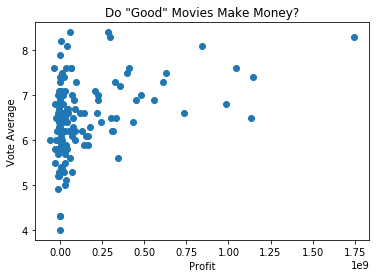%0A)

In \[38\]:

    # QUESTION: Does Popularity = Profit?
    plt.plot(movies_original_df.profit, movies_original_df.popularity, 'o')
    plt.title('Does Popularity = Profits?')
    plt.xlabel('Profit')
    plt.ylabel('Popularity')
    plt.show()

![](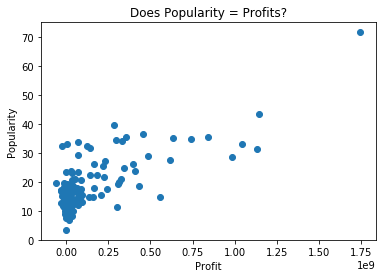%0A)

In \[65\]:

    # QUESTION: How does budget impact vote average?
    plt.plot(movies_original_df.budget, movies_original_df.vote_average, 'o')
    plt.title('How does Budget Impact Vote Average?')
    plt.xlabel('Budget')
    plt.ylabel('Vote Average')
    plt.show()

![](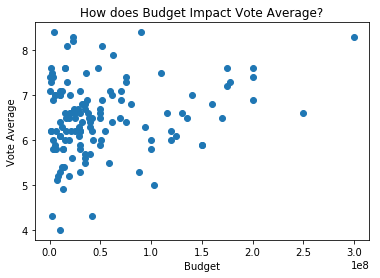%0A)

In \[66\]:

    # QUESTION: How does budget impact popularity?
    plt.plot(movies_original_df.budget, movies_original_df.popularity, 'o')
    plt.title('How does Budget Impact Popularity?')
    plt.xlabel('Budget')
    plt.ylabel('Popularity')
    plt.show()

![](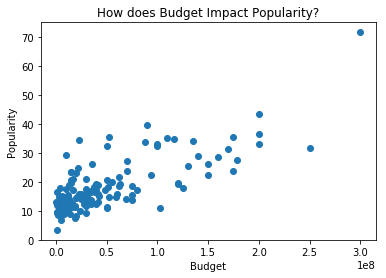%0A)

In \[69\]:

    # QUESTION: Is there a relationship between "Above Average Movies" and Budget/Price?
    below_avg = movies_original_df[movies_original_df.vote_average < 6.5]
    above_avg = movies_original_df[movies_original_df.vote_average >= 6.5]
    plt.plot(below_avg.budget, below_avg.profit, 'o', label="below average")
    plt.plot(above_avg.budget, above_avg.profit, 'o', label="above average")

    plt.title('BUDGET vs PROFIT by AVERAGE VOTE!')
    plt.xlabel('BUDGET')
    plt.ylabel('PROFIT')
    plt.legend()
    plt.show() 

![](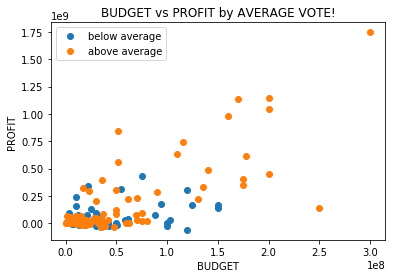%0A)

In \[70\]:

    # QUESTION: Is there a relationship between "Above Average Movies" and Budget/Price?
    below_avg = movies_original_df[movies_original_df.vote_average < 6.5]
    above_avg = movies_original_df[movies_original_df.vote_average >= 6.5]
    plt.plot(below_avg.budget, below_avg.percent_profit, 'o', label="below average")
    plt.plot(above_avg.budget, above_avg.percent_profit, 'o', label="above average")

    plt.title('BUDGET vs PERCENT PROFIT by AVERAGE VOTE!')
    plt.xlabel('BUDGET')
    plt.ylabel('PROFIT')
    plt.legend()
    plt.show() 

![](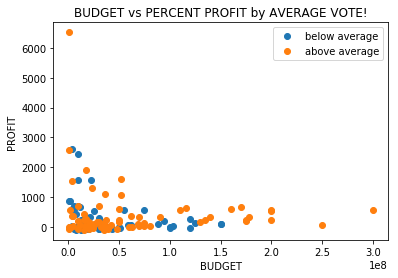%0A)

In \[71\]:

    # BIG QUESTION: What role do production companies play in the entertainment industry? 
    # Is there a relationship between production studio and average vote? 
    # Production studio and budget?
    # Production studio and percent profit?

In \[72\]:

    # Adding the BIG EIGHT Production Studios to the DF

    # WARNER BROS
    wb = []
    for movie in movies_original_df['production_companies']:
        if "Warner Bros" in movie:
            wb.append(True)
        else:
            wb.append(False)
    movies_original_df['wb'] = wb

    # MGM
    mgm = []
    for movie in movies_original_df['production_companies']:
        if "MGM" in movie:
            mgm.append(True)
        else:
            mgm.append(False)
    movies_original_df['mgm'] = mgm

    # DREAMWORKS
    dw = []
    for movie in movies_original_df['production_companies']:
        if "DreamWorks" in movie:
            dw.append(True)
        else:
            dw.append(False)
    movies_original_df['dw'] = dw

    # SONY
    sony = []
    for movie in movies_original_df['production_companies']:
        if "Sony" in movie:
            sony.append(True)
        else:
            sony.append(False)
    movies_original_df['sony'] = sony

    # DISNEY
    disney = []
    for movie in movies_original_df['production_companies']:
        if "Disney" in movie:
            disney.append(True)
        else:
            disney.append(False)
    movies_original_df['disney'] = disney

    #FOX
    fox = []
    for movie in movies_original_df['production_companies']:
        if "Century Fox" in movie:
            fox.append(True)
        else:
            fox.append(False)
    movies_original_df['fox'] = fox

    # PARAMOUNT
    paramount = []
    for movie in movies_original_df['production_companies']:
        if "Paramount" in movie:
            paramount.append(True)
        else:
            paramount.append(False)
    movies_original_df['paramount'] = paramount

    #UNIVERSAL
    universal = []
    for movie in movies_original_df['production_companies']:
        if "Universal" in movie:
            universal.append(True)
        else:
            universal.append(False)
    movies_original_df['universal'] = universal

In \[73\]:

    sony = movies_original_df[movies_original_df.sony == True]
    wb = movies_original_df[movies_original_df.wb == True]
    disney = movies_original_df[movies_original_df.disney == True]
    fox = movies_original_df[movies_original_df.fox == True]
    universal = movies_original_df[movies_original_df.universal == True]
    paramount = movies_original_df[movies_original_df.paramount == True]
    dw = movies_original_df[movies_original_df.dw == True]
    mgm = movies_original_df[movies_original_df.mgm == True]

    plt.plot(sony.budget, sony.revenue, 'o', label="Sony")
    plt.plot(wb.budget, wb.revenue, 'o', label="Warner Bros.")
    plt.plot(disney.budget, disney.revenue, 'o', label="Disney")
    plt.plot(fox.budget, fox.revenue, 'o', label="Fox")
    plt.plot(universal.budget, universal.revenue, 'o', label="Universal")
    plt.plot(paramount.budget, paramount.revenue, 'o', label="Paramount")
    plt.plot(dw.budget, dw.revenue, 'o', label="DreamWorks")
    plt.plot(mgm.budget, mgm.revenue, 'o', label="MGM")

    plt.title('BUDGET vs REVENUE by PRODUCTION COMPANY')
    plt.xlabel('BUDGET')
    plt.ylabel('REVENUE')
    plt.legend( loc = "lower center", bbox_to_anchor = (.5, -.4), ncol = 4, title = "Production Company")
    plt.show()

![](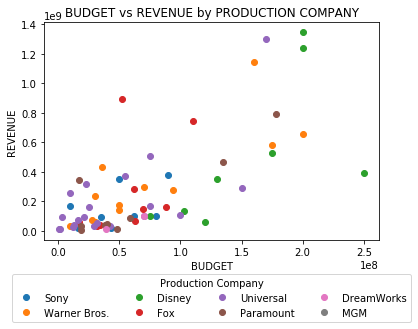%0A)

In \[74\]:

    sony = movies_original_df[movies_original_df.sony == True]
    wb = movies_original_df[movies_original_df.wb == True]
    disney = movies_original_df[movies_original_df.disney == True]
    fox = movies_original_df[movies_original_df.fox == True]
    universal = movies_original_df[movies_original_df.universal == True]
    paramount = movies_original_df[movies_original_df.paramount == True]
    dw = movies_original_df[movies_original_df.dw == True]
    mgm = movies_original_df[movies_original_df.mgm == True]

    plt.plot(sony.budget, sony.percent_profit, 'o', label="Sony")
    plt.plot(wb.budget, wb.percent_profit, 'o', label="Warner Bros.")
    plt.plot(disney.budget, disney.percent_profit, 'o', label="Disney")
    plt.plot(fox.budget, fox.percent_profit, 'o', label="Fox")
    plt.plot(universal.budget, universal.percent_profit, 'o', label="Universal")
    plt.plot(paramount.budget, paramount.percent_profit, 'o', label="Paramount")
    plt.plot(dw.budget, dw.percent_profit, 'o', label="DreamWorks")
    plt.plot(mgm.budget, mgm.percent_profit, 'o', label="MGM")

    plt.title('BUDGET vs PERCENT PROFIT by PRODUCTION COMPANY')
    plt.xlabel('BUDGET')
    plt.ylabel('PERCENT PROFIT')
    plt.legend( loc = "lower center", bbox_to_anchor = (.5, -.4), ncol = 4, title = "Production Company")
    plt.show()

![](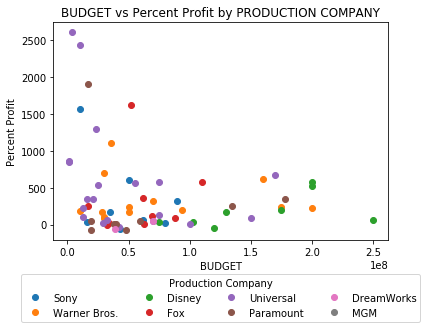%0A)

In \[ \]: